# Insurance Analysis

* [Initialization](#Initializations)
* [Data reading](#Data-reading)
* [Structure Investigation](#Structure-Investigation)
    * [Structure of non-numerical features](#Structure-of-non-numerical-features)
    * [Structure of numerical features](#Structure-of-numerical-features)
* [Quality Investigation](#Quality-Investigation)
    * [Duplicates](#Duplicates)
    * [Missing values](#Missing-values)
        * [Per sample](#Per-sample)
        * [Per features](#Per-features)
        * [Removing Nan Features](#Removing-Nan-Features)
* [Content Investigation](#Content-Investigation)
    * [Feature distribution](#Feature-distribution)
* [Continuous and discrete features](#Continuous-and-discrete-features)
    * [Comparing to selected feature: Score](#Comparing-to-selected-feature:-Score)
    * [Feature relationships](#Feature-relationships)
* [Data preprocessing](#Data-preprocessing)
    * [Date attributes](#Date-attributes)
    * [Categorical data](#Categorical-data)
        * [Gender](#Gender)
        * [Base categories](#Base-categories)
        * [Sub categories](#Sub-categories)
        * [Order city](#Order-city)
        * [Order region](#Order-region)
        * [Reward/Penalty Reasons](#Reward/Penalty-Reasons)
            * [extracting reasons and values as new features](#extracting-reasons-and-values-as-new-features)
            * [Reward/Penalty distributions](#Reward/Penalty-distributions)
   * [Contextual data analysis](#Contextual-data-analysis)
       * [Removing stop words](#Removing-stop-words)
       * [Removing duplicates](#Removing-duplicates)
       * [Clean text](#Clean-text)
       * [Lemmatization](#Lemmatization)
       * [Word clouds and top words](#Word-clouds-and-top-words)
           * [Comments](#Comments)
           * [Order Details](#Order-Details)
       * [Topic modeling of comments](#Topic-modeling-of-comments)
           * [Best params for LDA](#Best-params-for-LDA)
           * [Merging topic indexes with original df](#Merging-topic-indexes-with-original-df)
    * [Expert data](#Expert-data)
        * [Expert Scores](#Expert-Scores)
        * [Expert skills](#Expert-skills)
            * [Expert skills distribution](#Expert-skills-distribution)
            * [Expert skills word distributions](#Expert-skills-word-distributions)
            * [Adding expert skills top words as feature to main dataframe](#Adding-expert-skills-top-words-as-feature-to-main-dataframe)
            * [Removing One-hoted and useless columnes](#Removing-One-hoted-and-useless-columnes)
    * [Damages Data](#Damages-Data)
        * [Damage type](#Damage-type)
        * [Handing NaNs](#Handing-NaNs)
        * [Saving training data](#Saving-training-data)
* [Simple Classification](#Simple-Classification)
    * [Feature Selection](#Feature-Selection)
    * [Splitting train and test sets](#Splitting-train-and-test-sets)
        * [Original dataframe](#Original-dataframe)
        * [PCA feature reduction](#PCA-feature-reduction)
    * [Logistic regression](#Logistic-regression)
        * [LR with origin dataframe](#LR-with-origin-dataframe)
        * [LR with PCA](#LR-with-PCA)
    * [Decision Tree](#Decision-Tree)
        * [DT with original dataframe](#DT-with-original-dataframe)
        * [DT with PCA](#DT-with-PCA)
    * [Neural Networks](#Neural-Networks)
        * [NN with original dataframe](#NN-with-original-dataframe)
        * [NN with PCA](#NN-with-PCA)
    * [Predictions](#Predictions)
<br>

# Initialization

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud_fa import WordCloudFa
from matplotlib.pyplot import figure

import re
import copy
import time
import math
import datetime
import hazm
from hazm import stopwords_list
from hazm import word_tokenize
from cleantext import clean
from nltk.corpus import stopwords
from collections import Counter
import missingno as msno

import itertools

import scipy.stats as stats
from tqdm.notebook import tqdm
from bidi.algorithm import get_display
import arabic_reshaper
from hazm import word_tokenize

import collections


from IPython.core.display import display, HTML
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

base_path = "./data/"

In [ ]:
tqdm.pandas()

# Data reading

In [ ]:
data_path = "./AcharehDF.csv"

data_df = pd.read_csv(data_path)

In [ ]:
data_df.drop(['Unnamed: 0'],inplace=True,axis=1)

In [ ]:

data_df.head()

Expert Name  Expert Phone             Expert Joined on Gender  \
0      محمد علی رنجور  989124582705  2020-02-13T16:22:21.987774Z   MALE   
1        حسين سليمانی  989356285817  2018-10-15T09:10:15.686549Z   MALE   
2     نعمت کوهی یاملق  989197910832  2019-03-10T07:50:47.713583Z   MALE   
3  سید میلاد عبداللهی  989127783381  2019-08-08T04:00:42.142439Z   MALE   
4      محمد علی رنجور  989124582705  2020-02-13T16:22:21.987774Z   MALE   

       Customer Name  Customer Phone          Base Cat  \
0         ناصر سهیلی    9.891208e+11  باربری و جابجایی   
1     hamed hosseini    9.892132e+11           برقکاری   
2     hamed hosseini    9.892132e+11           برقکاری   
3  رامتین مهدیان راد    9.893552e+11           برقکاری   
4       مهیار بحرینی    9.891871e+11  باربری و جابجایی   

                                   Subcat                Status Order City  \
0  اسباب کشی و بسته‌ بندی (خاور و کامیون)  WORKMAN_NOT_SELECTED      تهران   
1               نصب و تعمیر آنتن تلویزیون                CLOSED      تهران   
2               نصب و تعمیر آنتن تلویزیون                CLOSED      تهران   
3                       سیم کشی و برقکاری                CLOSED      تهران   
4  اسباب کشی و بسته‌ بندی (خاور و کامیون)                CLOSED      تهران   

   ... Price Deductibles Incentives Promotion Percentage  Order Details  \
0  ...     0           0                             NaN            NaN   
1  ...     0           0                             NaN            NaN   
2  ...     0           0                             NaN            NaN   
3  ...     0           0                             NaN            NaN   
4  ...     0           0                             NaN            NaN   

  Expert Financial Rewards  Financial Rewards Reasons  \
0                      NaN                        NaN   
1                      NaN                        NaN   
2                      NaN                        NaN   
3                      NaN                        NaN   
4                      NaN                        NaN   

   Expert Financial Penalties  \
0                         NaN   
1                         NaN   
2                         NaN   
3          COMMISSION_PENALTY   
4                         NaN   

                         Financial Penalties Reasons  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  NON_HOURLY_DEMAND_FINALIZED_AUTOMATICALLY_AFTE...   
4                                                NaN   

                                      Legacy Comment  Frauds Description  
0                                                NaN                 NaN  
1                     از این آچار استفاده کنید.عالیه                 NaN  
2                     از این آچار استفاده کنید.عالیه                 NaN  
3  اصلا مسئولیت پذیر نبودن ،  خرابکاری کردن بجای ...                 NaN  
4  تیم درجه یک و عالی بسیار راضی بودیم خداوند خیر...                 NaN  

[5 rows x 25 columns]

# Structure Investigation

In [ ]:
data_df.shape

(2989150, 25)

In [ ]:
pd.value_counts(data_df.dtypes)

object     17
float64     5
int64       3
dtype: int64

## Structure of non-numerical features

In [ ]:
# Display non-numerical features
data_df.select_dtypes(exclude="number").head()

Expert Name             Expert Joined on Gender      Customer Name  \
0      محمد علی رنجور  2020-02-13T16:22:21.987774Z   MALE         ناصر سهیلی   
1        حسين سليمانی  2018-10-15T09:10:15.686549Z   MALE     hamed hosseini   
2     نعمت کوهی یاملق  2019-03-10T07:50:47.713583Z   MALE     hamed hosseini   
3  سید میلاد عبداللهی  2019-08-08T04:00:42.142439Z   MALE  رامتین مهدیان راد   
4      محمد علی رنجور  2020-02-13T16:22:21.987774Z   MALE       مهیار بحرینی   

           Base Cat                                  Subcat  \
0  باربری و جابجایی  اسباب کشی و بسته‌ بندی (خاور و کامیون)   
1           برقکاری               نصب و تعمیر آنتن تلویزیون   
2           برقکاری               نصب و تعمیر آنتن تلویزیون   
3           برقکاری                       سیم کشی و برقکاری   
4  باربری و جابجایی  اسباب کشی و بسته‌ بندی (خاور و کامیون)   

                 Status Order City Order Region          Desired Date  \
0  WORKMAN_NOT_SELECTED      تهران        فاطمی  2021-09-22T03:30:02Z   
1                CLOSED      تهران        سبلان  2019-05-26T03:30:01Z   
2                CLOSED      تهران        سبلان  2019-05-26T03:30:01Z   
3                CLOSED      تهران        تجریش  2020-01-30T08:30:02Z   
4                CLOSED      تهران     تهران نو  2020-05-21T02:30:02Z   

                 Creation Date Comment Order Details  \
0   2021-09-20T07:37:07.60008Z     NaN           NaN   
1  2019-06-05T21:36:59.463988Z     NaN           NaN   
2  2019-06-05T21:36:59.464242Z     NaN           NaN   
3  2020-01-24T07:13:05.884221Z     NaN           NaN   
4  2020-05-16T07:07:42.642232Z     NaN           NaN   

  Expert Financial Penalties  \
0                        NaN   
1                        NaN   
2                        NaN   
3         COMMISSION_PENALTY   
4                        NaN   

                         Financial Penalties Reasons  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  NON_HOURLY_DEMAND_FINALIZED_AUTOMATICALLY_AFTE...   
4                                                NaN   

                                      Legacy Comment Frauds Description  
0                                                NaN                NaN  
1                     از این آچار استفاده کنید.عالیه                NaN  
2                     از این آچار استفاده کنید.عالیه                NaN  
3  اصلا مسئولیت پذیر نبودن ،  خرابکاری کردن بجای ...                NaN  
4  تیم درجه یک و عالی بسیار راضی بودیم خداوند خیر...                NaN

In [ ]:
data_df.describe(exclude="number")

Expert Name      Expert Joined on   Gender Customer Name  \
count        2985941               2989150  2965399       2977887   
unique         14887                 16039        2        336384   
top     صفدر ولیپوری  2018-09-11T12:13:01Z     MALE                 
freq           25192                 25192  2749966          5007   

               Base Cat                 Subcat   Status Order City  \
count           2989150                2989150  1765769    2989150   
unique               41                    525        7         34   
top     تعمیرات ساختمان  تعمیر کولر آبی در محل   CLOSED      تهران   
freq             525218                 186295  1008068    2539825   

       Order Region          Desired Date                Creation Date  \
count       2989150               1765769                      2989150   
unique         1894                177667                      2974350   
top      سعادت آباد  2022-07-28T05:00:01Z  2022-07-31T12:34:39.372045Z   
freq          89652                   523                            4   

       Comment Order Details Expert Financial Penalties  \
count     7365          8881                      27462   
unique    6292          3569                          3   
top       عالی          فوری         COMMISSION_PENALTY   
freq       312           447                      17724   

                              Financial Penalties Reasons Legacy Comment  \
count                                               27462         263361   
unique                                                  9          90425   
top     NON_HOURLY_DEMAND_FINALIZED_AUTOMATICALLY_AFTE...           عالی   
freq                                                17649           9345   

           Frauds Description  
count                    5667  
unique                   1520  
top     300000 هزینه دریافتی   
freq                       99

## Structure of numerical features

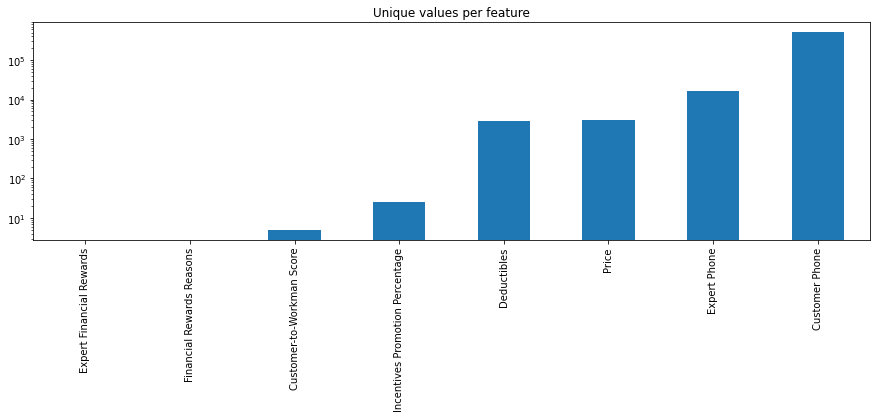

In [ ]:
# For each numerical feature compute number of unique entries
unique_values = data_df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

In [ ]:
data_df.describe(include="number")

Expert Phone  Customer Phone  Customer-to-Workman Score         Price  \
count  2.989150e+06    2.989136e+06                7365.000000  2.989150e+06   
mean   9.952392e+11    1.060863e+12                   4.495451  6.997266e+04   
std    1.230433e+12    8.249720e+12                   0.960031  1.102504e+06   
min    9.807100e+04    9.890000e+03                   1.000000  0.000000e+00   
25%    9.891241e+11    9.891229e+11                   4.000000  0.000000e+00   
50%    9.891386e+11    9.891279e+11                   5.000000  0.000000e+00   
75%    9.893032e+11    9.892126e+11                   5.000000  0.000000e+00   
max    9.800094e+14    9.894554e+14                   5.000000  1.000000e+09   

        Deductibles  Incentives Promotion Percentage  \
count  2.989150e+06                    312178.000000   
mean   3.605655e+04                        18.122600   
std    5.850858e+05                        20.127681   
min    0.000000e+00                         0.000000   
25%    0.000000e+00                         6.000000   
50%    0.000000e+00                        10.000000   
75%    0.000000e+00                        20.000000   
max    6.000000e+08                       100.000000   

       Expert Financial Rewards  Financial Rewards Reasons  
count                       0.0                        0.0  
mean                        NaN                        NaN  
std                         NaN                        NaN  
min                         NaN                        NaN  
25%                         NaN                        NaN  
50%                         NaN                        NaN  
75%                         NaN                        NaN  
max                         NaN                        NaN

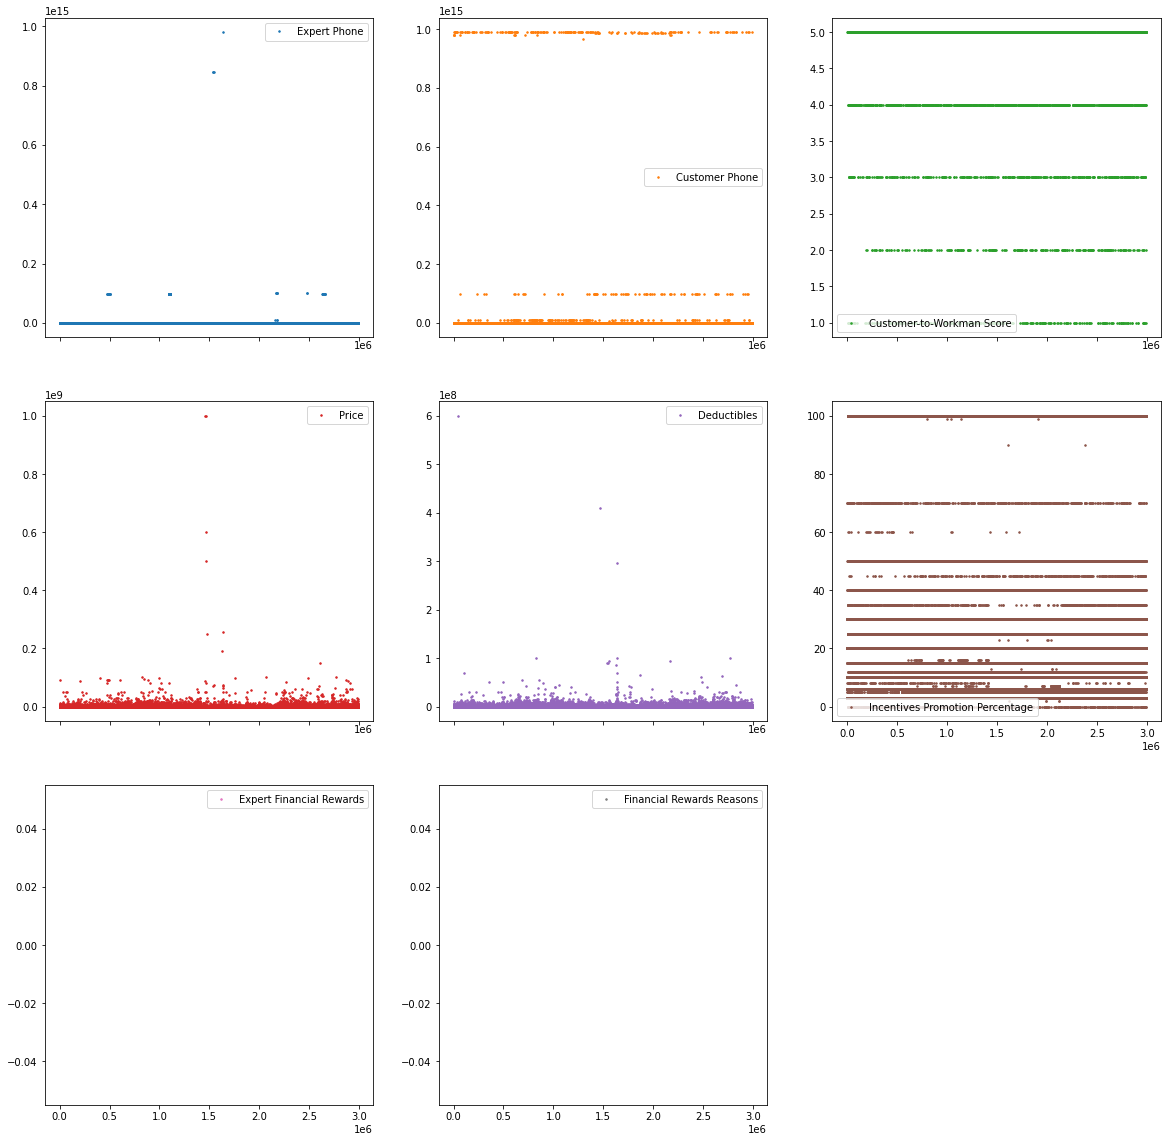

In [ ]:
data_df.plot(lw=0, marker=".", subplots=True, layout=(-1, 3), figsize=(20, 20), markersize=3);

# Quality Investigation

## Duplicates
Check if duplicates exists: An expert with multiple equal joined time.

In [ ]:
# Check number of duplicates while ignoring the index feature
n_duplicates = data_df.duplicated().sum()
print(f"You seem to have {n_duplicates} duplicates in your database.")

You seem to have 0 duplicates in your database.


In [ ]:
#  Extract column names of all features, except 'Accident_Index'
columns_to_consider = data_df.drop(labels=["Expert Phone", "Expert Joined on"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
data_df = data_df.drop_duplicates(subset=columns_to_consider)
data_df.shape

(2989150, 25)

## Missing values

### Per sample

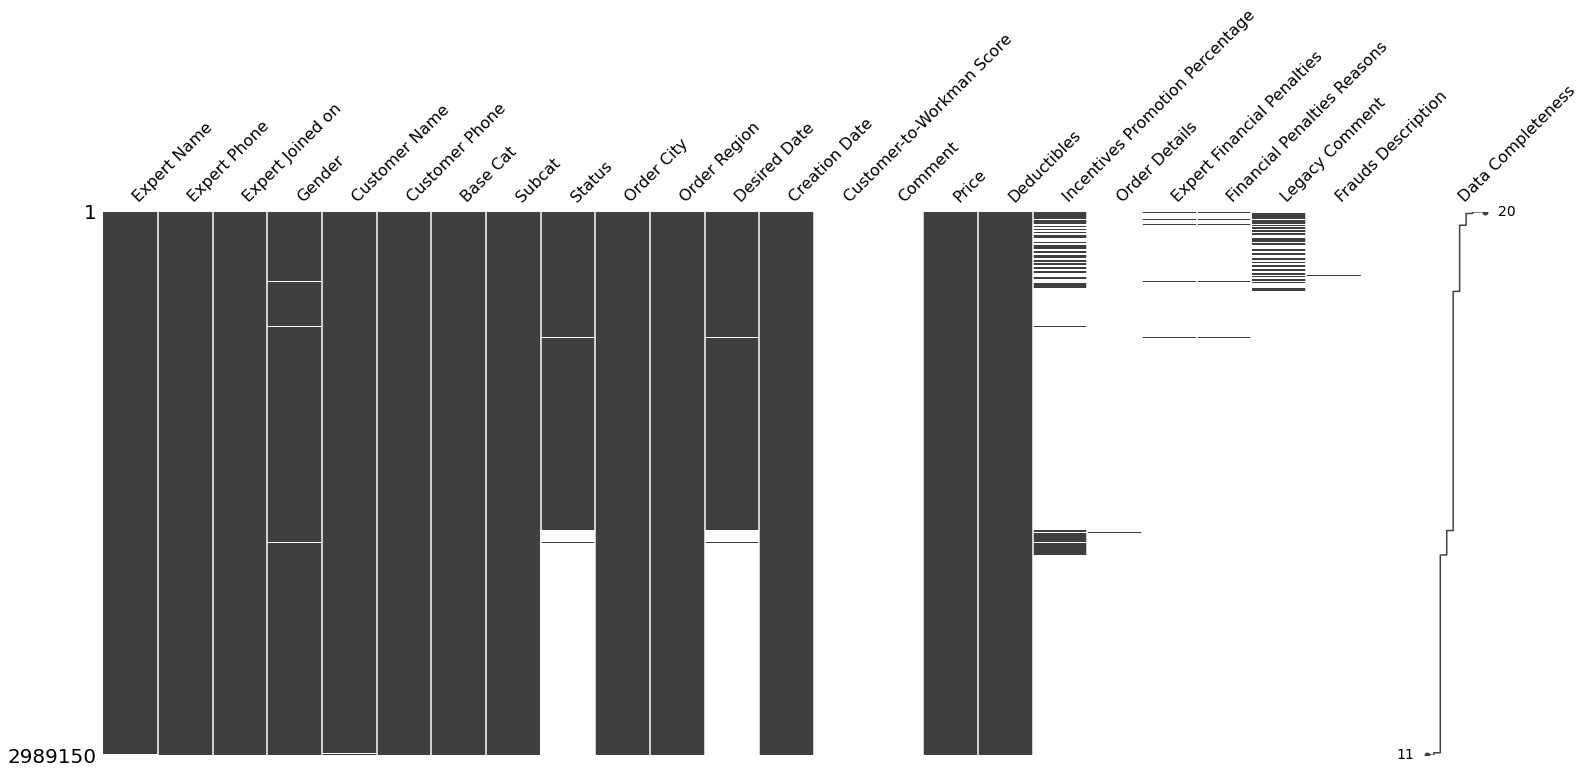

In [ ]:
msno.matrix(data_df, labels=True, sort="descending")

### Per features

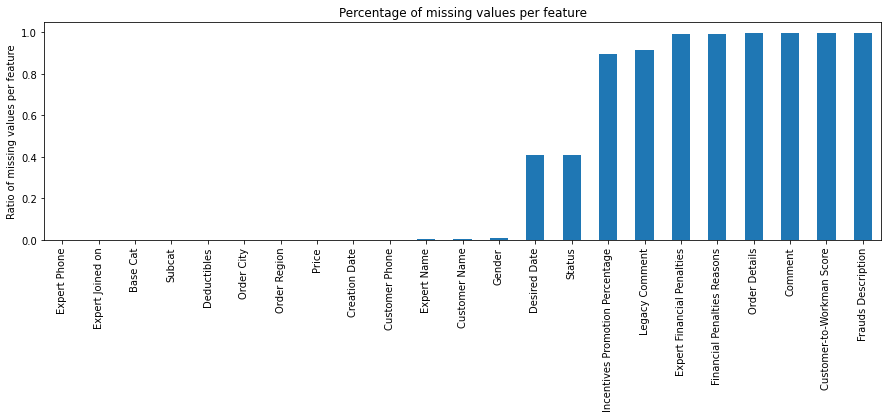

In [ ]:
data_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature")

### Removing Nan Features

In [ ]:
data_df = data_df.dropna(thresh=data_df.shape[0] * 0.001, axis=1)
data_df.shape

(2989150, 23)

# Content Investigation

## Feature distribution

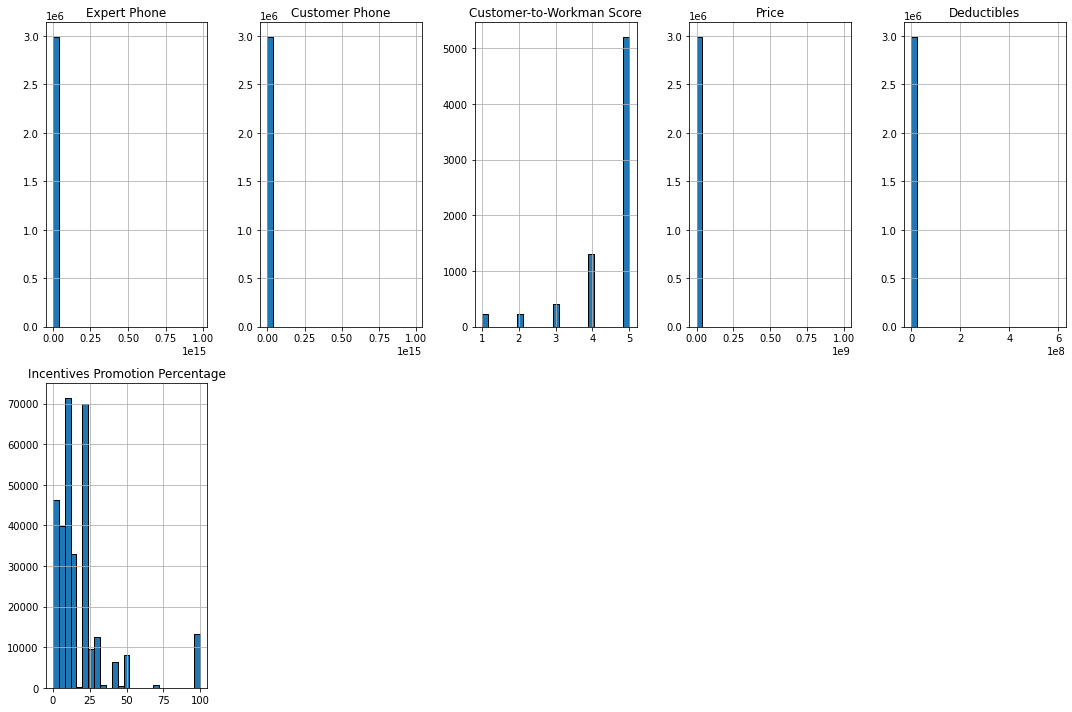

In [ ]:
data_df.hist(bins=25, figsize=(15, 10), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

# Continuous and discrete features

In [ ]:
cols_cont_disc = data_df.select_dtypes(include="number").nunique() < 3500

In [ ]:
# Create a new dataframe which only contains the continuous features
df_cols = data_df[cols_cont_disc[cols_cont_disc].index]
df_cols.shape

(2989150, 4)

<mark> Note: takes about 1.5 min to run </mark>

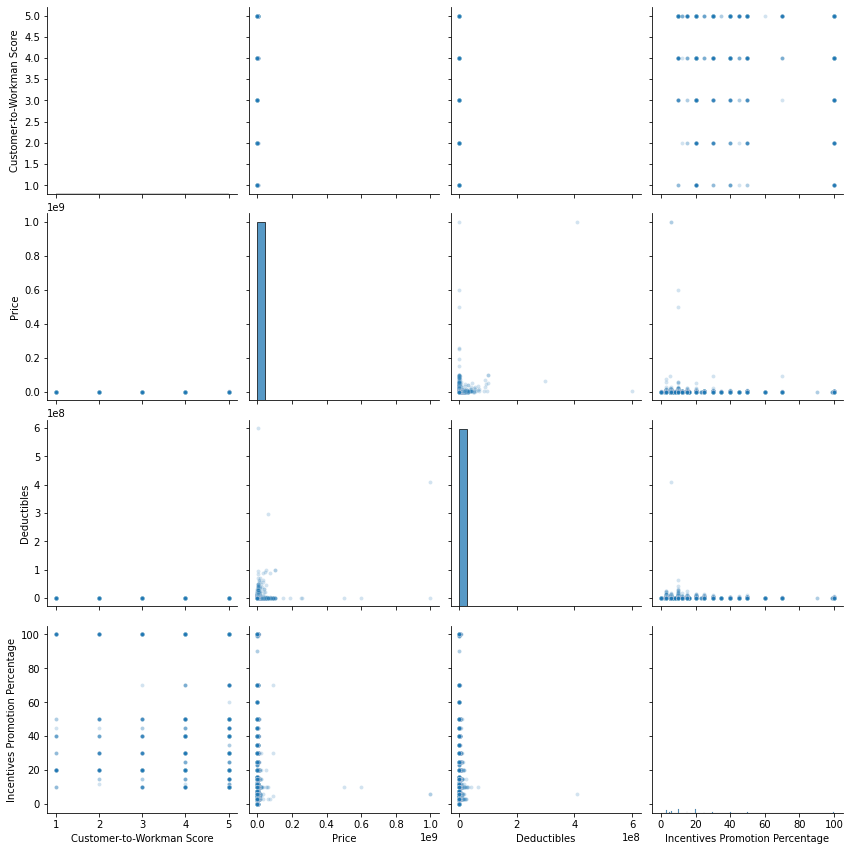

In [ ]:
sns.pairplot(df_cols, height=3, plot_kws={"s": 15, "alpha": 0.2});

## Comparing to selected feature: Score

0it [00:00, ?it/s]

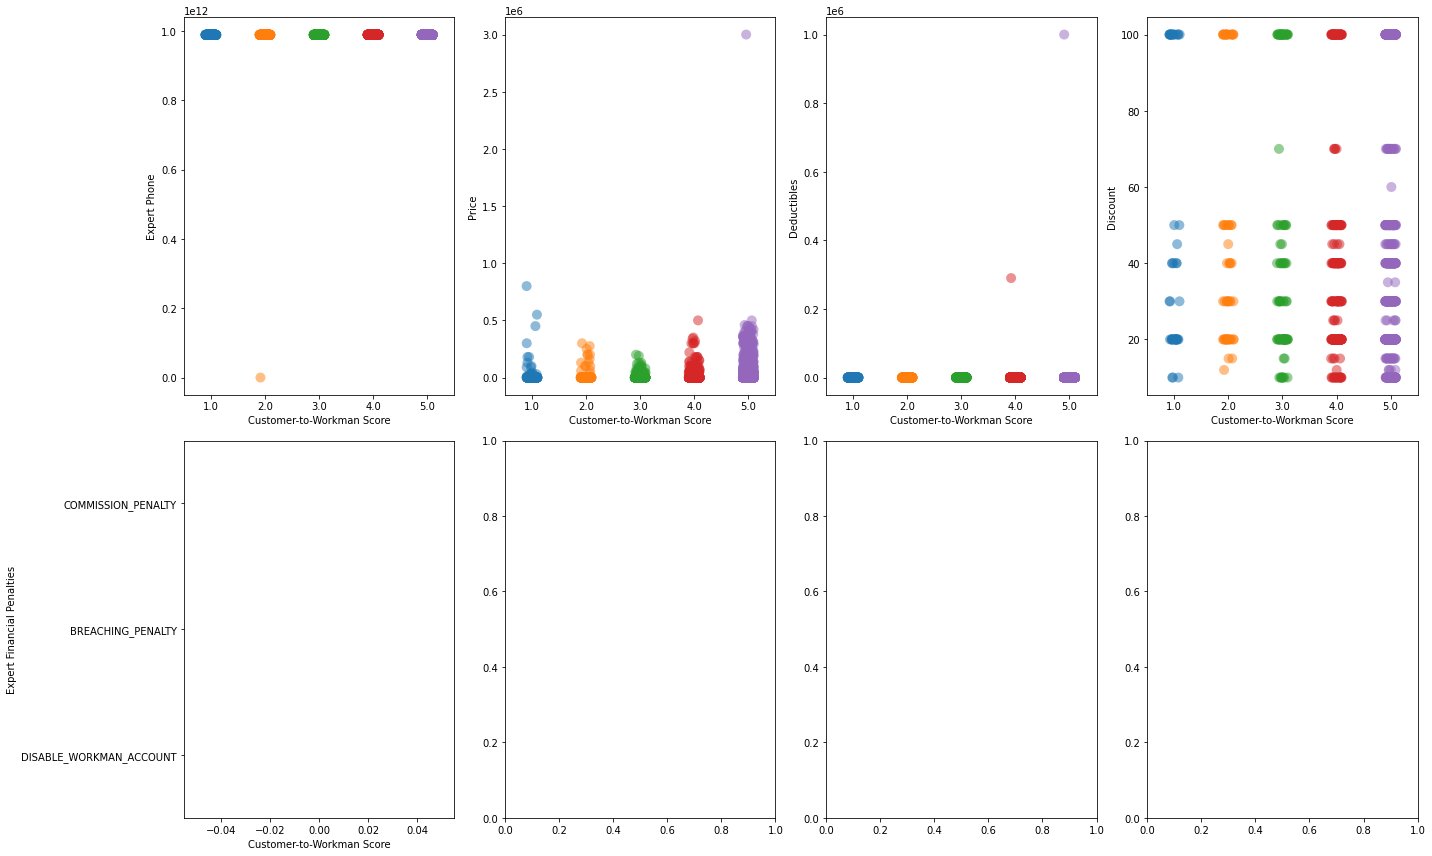

In [ ]:
# Specify features of interest
selected_features = ["Expert Phone", "Price", "Deductibles", "Discount",
                     "Expert Financial Penalties"]

# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 12))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in tqdm(zip(selected_features, axes.ravel())):
    sns.stripplot(data=data_df, y=col, x=data_df["Customer-to-Workman Score"], ax=ax,
                  palette="tab10", size=10, alpha=0.5)
plt.tight_layout();

## Feature relationships

In [ ]:
# Computes feature correlation
df_corr = data_df.corr(method="pearson")

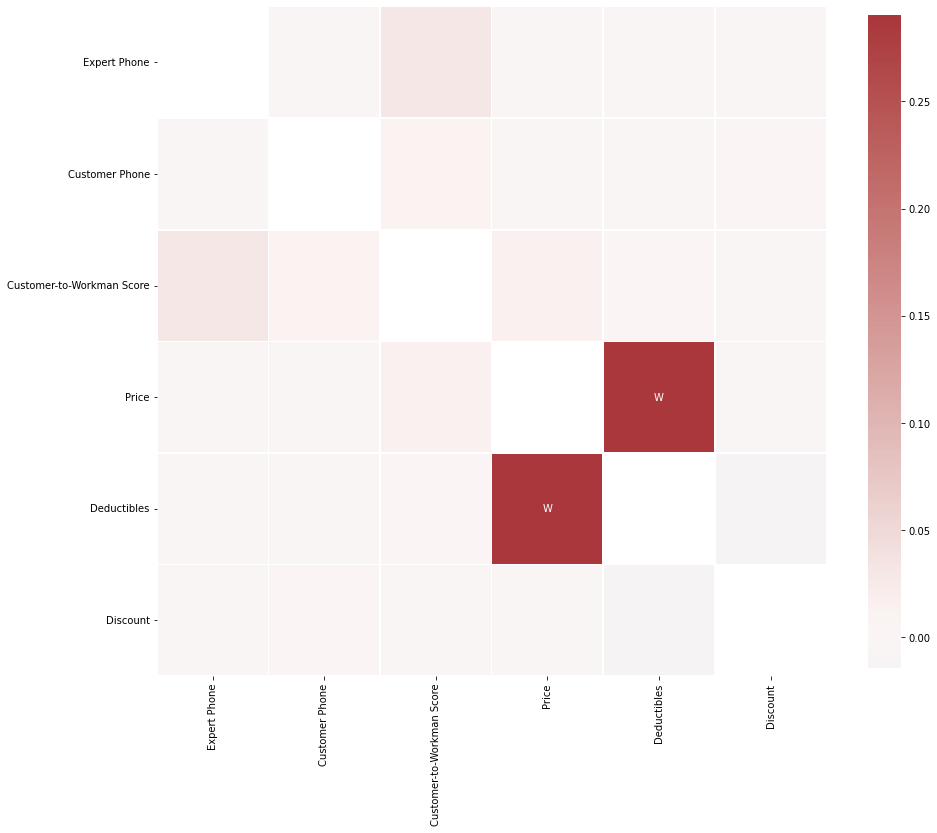

In [ ]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

# Data preprocessing

## Date attributes

In [ ]:
data_df['Expert Joined on'] = pd.to_datetime(data_df['Expert Joined on'])
data_df['Desired Date'] = pd.to_datetime(data_df['Desired Date'])
data_df['Creation Date'] = pd.to_datetime(data_df['Creation Date'])

In [ ]:
def get_date_attrs(col_name, df = data_df, attrs = ['y', 'm', 'd', 'w', 'h'], to_be_removed=False):
    if ('y' in attrs):
        df[col_name + '_year'] = df[col_name].dt.year
    if ('m' in attrs):
        df[col_name + '_month'] = df[col_name].dt.month
    if ('d' in attrs):
        df[col_name + '_day'] = df[col_name].dt.day
    if ('w' in attrs):
        df[col_name + '_day_of_week'] = df[col_name].dt.dayofweek
    if ('h' in attrs):
        df[col_name + '_hour'] = df[col_name].dt.hour
    if to_be_removed:
        del df[col_name]
        
def get_date_diffs(col_name1, col_name2, df = data_df, attrs = ['y', 'm', 'd', 'h']):
    if ('y' in attrs):
        df[col_name1 + '_to_' + col_name2 + '_year'] = df[col_name1].dt.year - df[col_name2].dt.year
    if ('m' in attrs):
        df[col_name1 + '_to_' + col_name2 + '_month'] = df[col_name1].dt.month - df[col_name2].dt.month
    if ('d' in attrs):
        df[col_name1 + '_to_' + col_name2 + '_day'] = df[col_name1].dt.day - df[col_name2].dt.day
    if ('h' in attrs):
        df[col_name1 + '_to_' + col_name2 + '_hour'] = df[col_name1].dt.hour - df[col_name2].dt.hour

In [ ]:
get_date_attrs('Expert Joined on')
get_date_attrs('Desired Date')
get_date_attrs('Creation Date')

get_date_diffs('Desired Date', 'Creation Date')
get_date_diffs('Expert Joined on', 'Desired Date')

In [ ]:
del data_df['Expert Joined on']
del data_df['Desired Date']
del data_df['Creation Date']

In [ ]:
data_df.head()

Expert Name  Expert Phone Gender      Customer Name  Customer Phone  \
0      محمد علی رنجور  989124582705   MALE         ناصر سهیلی    9.891208e+11   
1        حسين سليمانی  989356285817   MALE     hamed hosseini    9.892132e+11   
2     نعمت کوهی یاملق  989197910832   MALE     hamed hosseini    9.892132e+11   
3  سید میلاد عبداللهی  989127783381   MALE  رامتین مهدیان راد    9.893552e+11   
4      محمد علی رنجور  989124582705   MALE       مهیار بحرینی    9.891871e+11   

           Base Cat                                  Subcat  \
0  باربری و جابجایی  اسباب کشی و بسته‌ بندی (خاور و کامیون)   
1           برقکاری               نصب و تعمیر آنتن تلویزیون   
2           برقکاری               نصب و تعمیر آنتن تلویزیون   
3           برقکاری                       سیم کشی و برقکاری   
4  باربری و جابجایی  اسباب کشی و بسته‌ بندی (خاور و کامیون)   

                 Status Order City Order Region  ...  \
0  WORKMAN_NOT_SELECTED      تهران        فاطمی  ...   
1                CLOSED      تهران        سبلان  ...   
2                CLOSED      تهران        سبلان  ...   
3                CLOSED      تهران        تجریش  ...   
4                CLOSED      تهران     تهران نو  ...   

   Creation Date_day_of_week Creation Date_hour  \
0                          0                  7   
1                          2                 21   
2                          2                 21   
3                          4                  7   
4                          5                  7   

   Desired Date_to_Creation Date_year  Desired Date_to_Creation Date_month  \
0                                 0.0                                  0.0   
1                                 0.0                                 -1.0   
2                                 0.0                                 -1.0   
3                                 0.0                                  0.0   
4                                 0.0                                  0.0   

   Desired Date_to_Creation Date_day Desired Date_to_Creation Date_hour  \
0                                2.0                               -4.0   
1                               21.0                              -18.0   
2                               21.0                              -18.0   
3                                6.0                                1.0   
4                                5.0                               -5.0   

  Expert Joined on_to_Desired Date_year  \
0                                  -1.0   
1                                  -1.0   
2                                   0.0   
3                                  -1.0   
4                                   0.0   

  Expert Joined on_to_Desired Date_month Expert Joined on_to_Desired Date_day  \
0                                   -7.0                                 -9.0   
1                                    5.0                                -11.0   
2                                   -2.0                                -16.0   
3                                    7.0                                -22.0   
4                                   -3.0                                 -8.0   

  Expert Joined on_to_Desired Date_hour  
0                                  13.0  
1                                   6.0  
2                                   4.0  
3                                  -4.0  
4                                  14.0  

[5 rows x 43 columns]

## Categorical data

In [ ]:
def show_col_unique_vals(df=data_df):
    for col in df.columns:
        item_counts = df[col].nunique()
        print(col, ":", item_counts)
show_col_unique_vals()

Expert Name : 14887
Expert Phone : 16040
Gender : 2
Customer Name : 336384
Customer Phone : 511897
Base Cat : 41
Subcat : 525
Status : 7
Order City : 34
Order Region : 1894
Customer-to-Workman Score : 5
Comment : 6292
Price : 3114
Deductibles : 2806
Discount : 25
Order Details : 3569
Expert Financial Rewards : 0
Financial Rewards Reasons : 0
Expert Financial Penalties : 3
Financial Penalties Reasons : 9
Legacy Comment : 90425
Frauds Description : 1520
Expert Joined on_year : 6
Expert Joined on_month : 12
Expert Joined on_day : 31
Expert Joined on_day_of_week : 7
Expert Joined on_hour : 24
Desired Date_year : 6
Desired Date_month : 12
Desired Date_day : 31
Desired Date_day_of_week : 7
Desired Date_hour : 24
Creation Date_year : 4
Creation Date_month : 12
Creation Date_day : 31
Creation Date_day_of_week : 7
Creation Date_hour : 24
Desired Date_to_Creation Date_year : 5
Desired Date_to_Creation Date_month : 22
Desired Date_to_Creation Date_day : 61
Desired Date_to_Creation Date_hour : 47


In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()        

def convert_categorical_data(col_name, encoding_type='one-hot', valid_cols = [], is_valid_cols_set = False): # encoding types: one-hot, labeling
    if encoding_type == 'one-hot':
        global data_df
        unique_vals = list(data_df[col_name].unique())
        data_df = pd.concat([data_df,pd.get_dummies(data_df[col_name], prefix = col_name)],axis=1).drop([col_name],axis=1)
        
        if is_valid_cols_set:
            invalid_cols = []
            for col in unique_vals:
                if (col not in valid_cols):
                    invalid_cols.append(col_name + '_' + col)
            data_df.drop(invalid_cols, axis = 1, inplace = True)
            
    elif encoding_type == 'labeling':
        data_df[col_name] = labelencoder.fit_transform(data_df[col_name])

### Gender

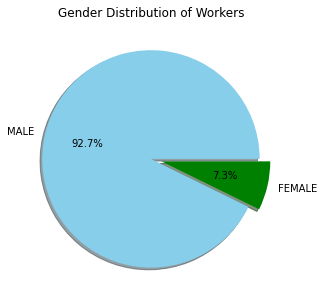

In [ ]:
data_df['Gender'].value_counts().plot(kind='pie', figsize=(5,5), shadow=True, startangle=0, title = 'Gender Distribution of Workers',
                                      autopct='%1.1f%%', explode=(0, 0.1), colors = ['skyblue', 'green'], ylabel = '')

data_df['Gender'] = data_df['Gender'].map({'MALE': 1, 'FEMALE': 0})

In [ ]:
convert_categorical_data('Gender', 'one-hot')

### Base categories

In [ ]:
def make_farsi_text(x):
    reshaped_text = arabic_reshaper.reshape(x)
    farsi_text = get_display(reshaped_text)
    return farsi_text

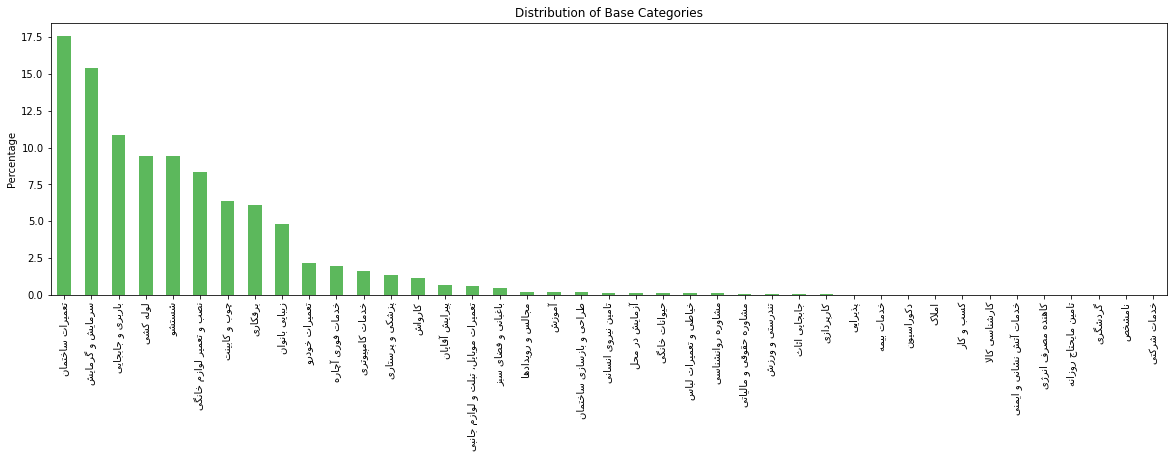

In [ ]:
normal_base_categories = data_df['Base Cat'].value_counts(normalize=True)* 100
base_categories = data_df['Base Cat'].value_counts(normalize=True)* 100
for cat_key in base_categories.keys():
    base_categories[make_farsi_text(cat_key)] = base_categories.pop(cat_key)
p2 = base_categories.plot(kind='bar', figsize=(20,5), title='Distribution of Base Categories',
                                                          ylabel = 'Percentage', color= '#5cb85c')
# for p in p2.containers:
#     p2.bar_label(p, fmt='%.2f', label_type='edge')

In [ ]:
convert_categorical_data('Base Cat', 'one-hot')

### Sub categories

Number of sub categories: 222. So we include only those large categories which cover around <mark>80%</mark> of all sub categories.

In [ ]:
coverage_perc = 80

normal_sub_categories = data_df['Subcat'].value_counts(normalize=True)* 100
sub_categories = data_df['Subcat'].value_counts(normalize=True)* 100
for cat_key in sub_categories.keys():
    sub_categories[make_farsi_text(cat_key)] = sub_categories.pop(cat_key)

coverage = 0
index = 0
valid_cols = []
for i in range(len(normal_sub_categories)):
    coverage += normal_sub_categories.iloc[i]
    valid_cols.append(normal_sub_categories.index[i])
    
    if coverage >= coverage_perc:
        print("sub-categories:", i)
        index = i
        break

sub-categories: 48


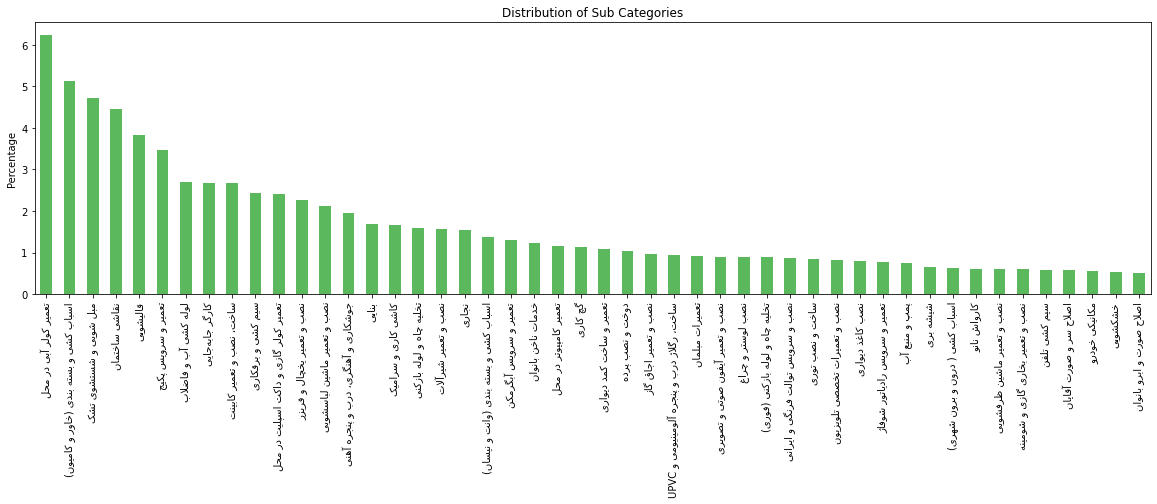

In [ ]:
p2 = sub_categories[:index].plot(kind='bar', figsize=(20,5), title='Distribution of Sub Categories',
                                                          ylabel = 'Percentage', color= '#5cb85c')

In [ ]:
convert_categorical_data('Subcat', 'one-hot', valid_cols, True)

### Order city

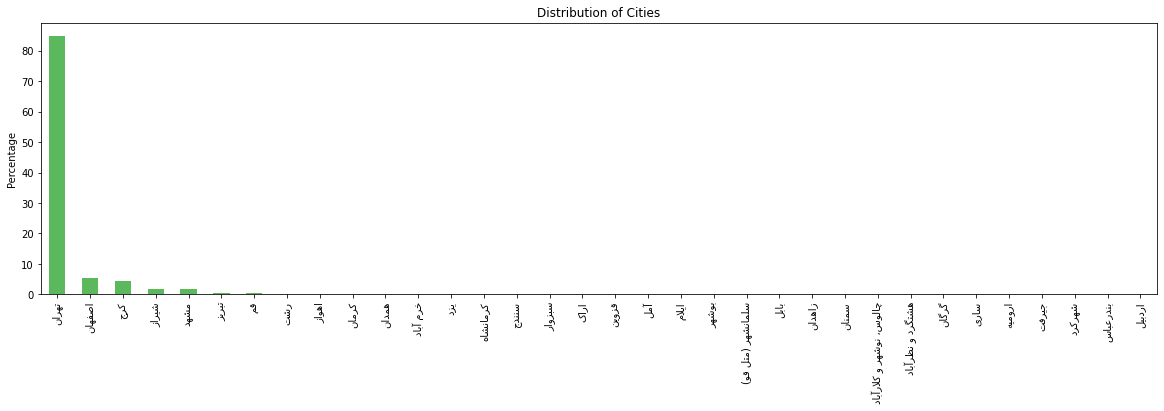

In [ ]:
city_categories = data_df['Order City'].value_counts(normalize=True)* 100
for cat_key in city_categories.keys():
    city_categories[make_farsi_text(cat_key)] = city_categories.pop(cat_key)
p2 = city_categories.plot(kind='bar', figsize=(20,5), title='Distribution of Cities',
                                                          ylabel = 'Percentage', color= '#5cb85c')

Orders from outside of 'Tehran' : <mark>0.33%</mark> of all data, so we wipe This column.

In [ ]:
out_of_tehran_orders = len(data_df[data_df['Order City'] != 'تهران'])
print("count:", out_of_tehran_orders, "percentage:", "{:.2f}".format(out_of_tehran_orders/len(data_df)*100))

count: 449325 percentage: 15.03


In [ ]:
data_df.drop(['Order City'], axis = 1, inplace = True)

### Order region

Number of order regions: 431. So we include only those large categories which cover around <mark>60%</mark> of all sub categories.

In [ ]:
coverage_perc = 60

normal_order_regions = data_df['Order Region'].value_counts(normalize=True)* 100
order_regions = data_df['Order Region'].value_counts(normalize=True)* 100
for cat_key in order_regions.keys():
    order_regions[make_farsi_text(cat_key)] = order_regions.pop(cat_key)

coverage = 0
index = 0
valid_cols = []
for i in range(len(normal_order_regions)):
    coverage += normal_order_regions.iloc[i]
    valid_cols.append(normal_order_regions.index[i])
    
    if coverage >= coverage_perc:
        print("order regions:", i)
        index = i
        break

order regions: 88


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


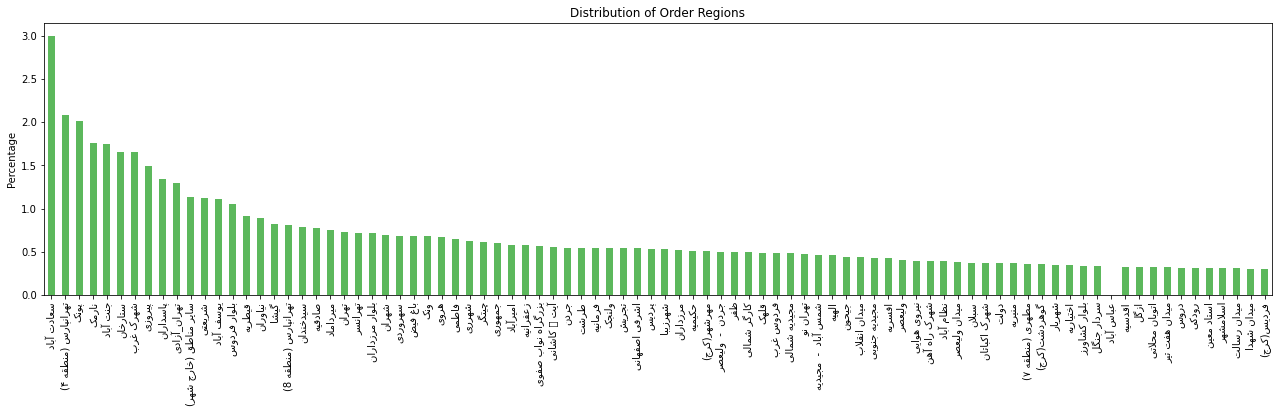

In [ ]:
p2 = order_regions[:index].plot(kind='bar', figsize=(22,5), title='Distribution of Order Regions',
                                                          ylabel = 'Percentage', color= '#5cb85c')

In [ ]:
convert_categorical_data('Order Region', 'one-hot', valid_cols, True)

In [ ]:
data_df.head()

### Reward/Penalty Reasons

> Indented block



#### extracting reasons and values as new features

In [ ]:
reward_reason_types = set()
penalty_reason_types = set()

def get_clean_reason_form(reasons, reasons_type):
    reason_list = reasons.split(',')
   
    reason_dict = {}
    for reason in reason_list:
        reason_items = reason.split(':')
        reason_items = [r.strip() for r in reason_items]
        if len(reason_items) > 1:
          reason_dict[reason_items[0]] = int(reason_items[1])
        else:
          reason_dict[reason_items[0]] = 1
        
        if (reasons_type == 'reward'):
            reward_reason_types.add(reason_items[0])
        elif (reasons_type == 'penalty'):
            penalty_reason_types.add(reason_items[0])
    return reason_dict

In [ ]:
no_reward_keyword = 'NO_REWARD: 0'
no_penalty_keyword = 'NO_PENALTY: 0'

data_df['Financial Rewards Reasons'].fillna(no_reward_keyword, inplace=True)
data_df['Financial Penalties Reasons'].fillna(no_penalty_keyword, inplace=True)

commission_rewards = data_df['Financial Rewards Reasons'].apply(lambda r: get_clean_reason_form(r, 'reward'))
commission_penalties = data_df['Financial Penalties Reasons'].apply(lambda r: get_clean_reason_form(r, 'penalty'))

In [ ]:
def extend_reason_dict(reasons, reason_types):
    for reason_type in reason_types:
        if reason_type not in reasons:
            reasons[reason_type] = 0
    return reasons

commission_rewards = commission_rewards.apply(lambda r: extend_reason_dict(r, reward_reason_types))
commission_penalties = commission_penalties.apply(lambda r: extend_reason_dict(r, penalty_reason_types))

In [ ]:
data_df = pd.concat([data_df,pd.DataFrame(list(commission_rewards))],axis=1).drop(['Financial Rewards Reasons'],axis=1)
data_df = pd.concat([data_df,pd.DataFrame(list(commission_penalties))],axis=1).drop(['Financial Penalties Reasons'],axis=1)

In [ ]:
data_df.head()

Expert Name  Expert Phone      Customer Name  Customer Phone  \
0      محمد علی رنجور  989124582705         ناصر سهیلی    9.891208e+11   
1        حسين سليمانی  989356285817     hamed hosseini    9.892132e+11   
2     نعمت کوهی یاملق  989197910832     hamed hosseini    9.892132e+11   
3  سید میلاد عبداللهی  989127783381  رامتین مهدیان راد    9.893552e+11   
4      محمد علی رنجور  989124582705       مهیار بحرینی    9.891871e+11   

           Base Cat                                  Subcat  \
0  باربری و جابجایی  اسباب کشی و بسته‌ بندی (خاور و کامیون)   
1           برقکاری               نصب و تعمیر آنتن تلویزیون   
2           برقکاری               نصب و تعمیر آنتن تلویزیون   
3           برقکاری                       سیم کشی و برقکاری   
4  باربری و جابجایی  اسباب کشی و بسته‌ بندی (خاور و کامیون)   

                 Status Order City Order Region  Customer-to-Workman Score  \
0  WORKMAN_NOT_SELECTED      تهران        فاطمی                        NaN   
1                CLOSED      تهران        سبلان                        NaN   
2                CLOSED      تهران        سبلان                        NaN   
3                CLOSED      تهران        تجریش                        NaN   
4                CLOSED      تهران     تهران نو                        NaN   

   ... NO_PENALTY  BREACHING_A_CRITICAL_CONTRACT  ADMIN_FINALIZED_A_DEMAND  \
0  ...          0                              0                         0   
1  ...          0                              0                         0   
2  ...          0                              0                         0   
3  ...          0                              0                         0   
4  ...          0                              0                         0   

   BREACHING_A_NON_CRITICAL_CONTRACT HOURLY_DEMAND_FINALIZED_AUTOMATICALLY  \
0                                  0                                     0   
1                                  0                                     0   
2                                  0                                     0   
3                                  0                                     0   
4                                  0                                     0   

   WORKMAN_REQUEST_ORDER_CANCELLATION ABSENT_WORKMAN  \
0                                   0              0   
1                                   0              0   
2                                   0              0   
3                                   0              0   
4                                   0              0   

  WORKMAN_DISHONEST_CANCELLATION BREACHING_A_CRITICAL_CLEANING_CONTRACT  \
0                              0                                      0   
1                              0                                      0   
2                              0                                      0   
3                              0                                      0   
4                              0                                      0   

   NON_HOURLY_DEMAND_FINALIZED_AUTOMATICALLY_AFTER_30_DAYS  
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  1        
4                                                  0        

[5 rows x 55 columns]

<br>

#### Reward/Penalty distributions

In [ ]:
def get_reason_counts(reasons):
    reason_counts = {}
    for r in reasons:
        reason_counts[r] = len(data_df[data_df[r] != 0])
    return reason_counts

In [ ]:
reward_reasons_counts = get_reason_counts(reward_reason_types)
penalty_reasons_counts = get_reason_counts(penalty_reason_types)

In [ ]:
penalty_reasons_counts

{'BREACHING_A_CRITICAL_CONTRACT': 4174,
 'ADMIN_FINALIZED_A_DEMAND': 39,
 'BREACHING_A_NON_CRITICAL_CONTRACT': 5206,
 'HOURLY_DEMAND_FINALIZED_AUTOMATICALLY': 37,
 'WORKMAN_REQUEST_ORDER_CANCELLATION': 23,
 'ABSENT_WORKMAN': 26,
 'WORKMAN_DISHONEST_CANCELLATION': 299,
 'BREACHING_A_CRITICAL_CLEANING_CONTRACT': 9,
 'NO_PENALTY': 0,
 'NON_HOURLY_DEMAND_FINALIZED_AUTOMATICALLY_AFTER_30_DAYS': 17649}

Text(0, 0.5, 'Count')

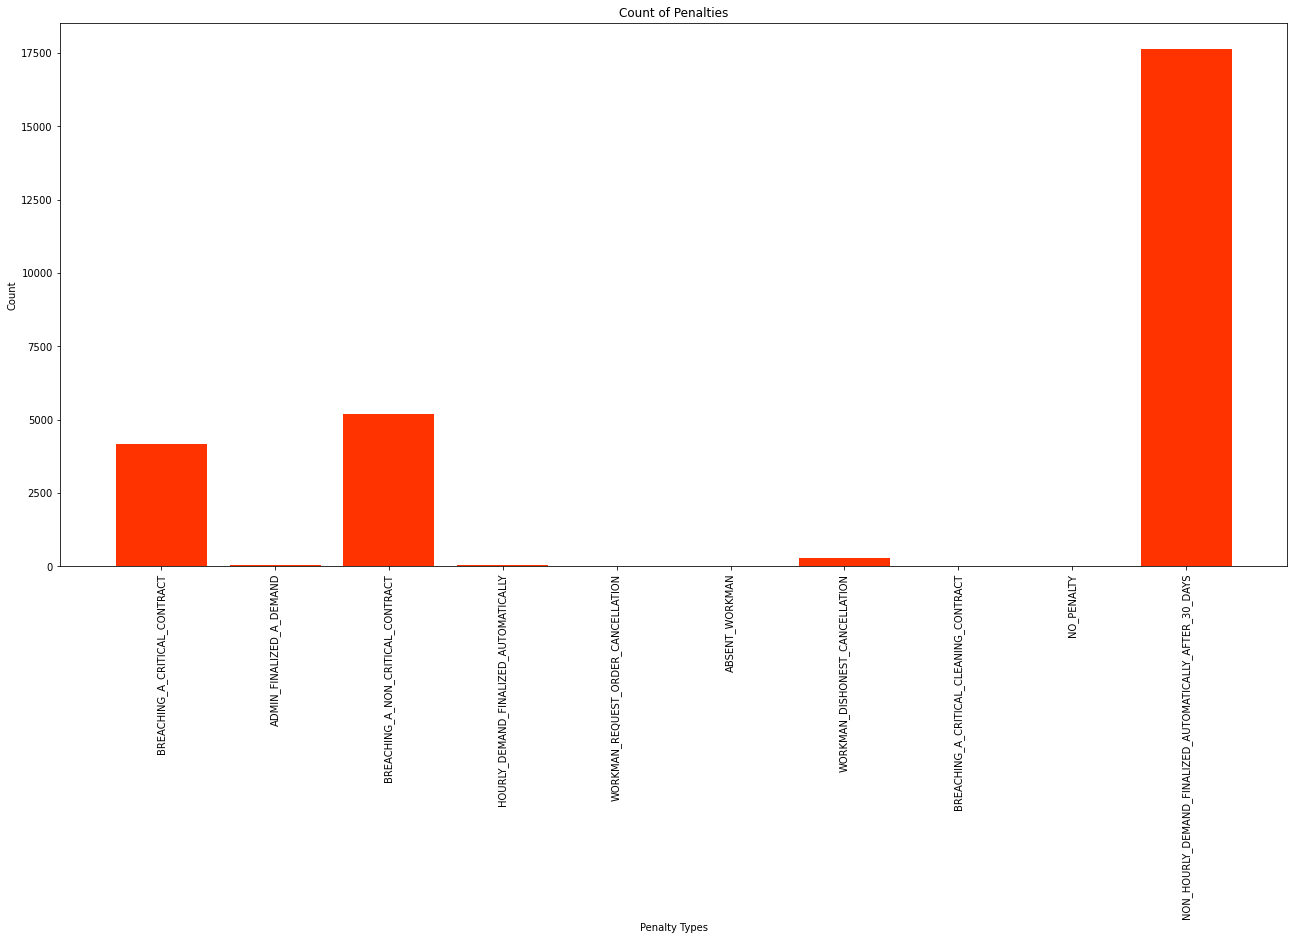

In [ ]:
colors = ['#33cc33', '#ff3300']
fig, ax2 = plt.subplots(1, 1, figsize=(22,10))

ax2.bar(range(len(penalty_reasons_counts)), list(penalty_reasons_counts.values()), color=colors[1])   
plt.sca(ax2)
plt.xticks(range(len(penalty_reasons_counts)), list(penalty_reasons_counts.keys()), rotation=90)
ax2.set_title('Count of Penalties')
ax2.set_xlabel('Penalty Types')
ax2.set_ylabel('Count')

## Contextual data analysis

### Removing stop words

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words_fa = set(stopwords_list()) 
stop_words_en = set(stopwords.words('english'))

bullshitsFile = open(base_path + 'stop-words/bullshits.txt',  encoding="utf8")
charsFile = open(base_path + 'stop-words/chars.txt',  encoding="utf8")
infinitivesFile = open(base_path + 'stop-words/infinitives.txt',  encoding="utf8")
nonverbalFile = open(base_path + 'stop-words/nonverbal.txt',  encoding="utf8")
persianFile = open(base_path + 'stop-words/persian.txt',  encoding="utf8")
shortFile = open(base_path + 'stop-words/short.txt',  encoding="utf8")
verbalFile = open(base_path + 'stop-words/verbal.txt',  encoding="utf8")

bullshits = set(line.strip() for line in bullshitsFile)
chars = set(line.strip() for line in charsFile)
infinitives = set(line.strip() for line in infinitivesFile)
nonverbal = set(line.strip() for line in nonverbalFile)
persian = set(line.strip() for line in persianFile)
short = set(line.strip() for line in shortFile)
verbal = set(line.strip() for line in verbalFile)

stop_words = stop_words_fa.union(stop_words_en)
stop_words = stop_words.union(bullshits)
stop_words = stop_words.union(chars)
stop_words = stop_words.union(infinitives)
stop_words = stop_words.union(nonverbal)
stop_words = stop_words.union(persian)
stop_words = stop_words.union(short)
stop_words = stop_words.union(verbal)

extra_stopwords = {
    'Comment': {'سلام', 'بشه', '۱۵۰', '۲۰۰', 'میشد', '۲۵۰', 'نظرم', 'کار', 'کارها', 'صورت', 'بدم', 'صد', 'میکردن', 'هزار', 'برام', 'کارم', 'پور', 'کشی', 'انجام'},
    'Legacy Comment': {'سلام', 'بشه', '۱۵۰', '۲۰۰', 'میشد', '۲۵۰', 'نظرم', 'کار', 'کارها', 'صورت', 'بدم', 'صد', 'میکردن', 'هزار', 'برام', 'کارم', 'پور', 'کشی', 'انجام'},
    'Frauds Description': {'سلام', 'بشه', '۱۵۰', '۲۰۰', 'میشد', '۲۵۰', 'نظرم', 'کار', 'کارها', 'صورت', 'بدم', 'صد', 'میکردن', 'هزار', 'برام', 'کارم', 'پور', 'کشی', 'انجام'},
    'Order Details': {'لطفا', 'سلام', 'بشه', 'عدد', 'میشه', 'میشود', 'میشوند', 'کشی', 'میباشد', 'می‌باشد'},
    'Skills': {}
}

def SimpleremoveStopwords(text, extra=''): # extra = 'comment' or 'order-details' or 'skills'
    tokens = word_tokenize(text)
   
    tokens_without_sw = [word for word in tokens if not word in stop_words]
    if extra != '':
        tokens_without_sw = [word for word in tokens_without_sw if not word in extra_stopwords[extra]]
   
    text = " ".join([word for word in tokens_without_sw])
    return text

### Removing duplicates

In [ ]:
emojiesFile = open(base_path + 'emojies.txt',  encoding="utf8")
emojies = list(line.strip() for line in emojiesFile)
emojiesStr = ' '.join(e for e in emojies)
pattern = "(?P<char>[" + re.escape(emojiesStr) + "])(?P=char)*"

def removeDuplicates(text) : 
    dups = re.finditer(r"(.)\1{2,}", text)
    dupList = []
    for d in dups:
        dupList.append(d.group())
    
    for d in dupList:
        text = text.replace(d, d[0]) #reduce chars with 3 or more repeats in a row to 1
    
    text = re.sub(pattern, r" \1 ", text) #reduce emoji repeats to 1 and separate it from other tokens
    return text

### Clean text

In [ ]:
normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()

punctuationsFile = open(base_path + 'stop-words/punctuations.txt',  encoding="utf8")
punctuations = set(line.strip() for line in punctuationsFile)

removeSpaceList = ['_', '\s+']
removeList = [r"http\S+"]

wierd_pattern = re.compile("["
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)



def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def cleanText(text) :
    text = str(text).strip()
    if text == '':
      return ''
    text = clean(text)
    
    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    text = wierd_pattern.sub(r'', text)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    
    # removing unncessary characters and punctuations
    for r in removeList:
        text = re.sub(r, '', text)
    for r in removeSpaceList:
        text = text.replace(r, ' ')
    for p in punctuations:
        text = text.replace(p, ' ')
        
    text = re.sub(' +', ' ', text)
    return text

### Lemmatization

In [ ]:
def lemmatizeText(text) : 
    return " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

In [ ]:
def clean_col(col_name):    
    print("cleaning", col_name)
    
    data_df[col_name].fillna('', inplace=True)

    data_df[col_name] = data_df[col_name].progress_apply(lambda t: removeDuplicates(t))
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: cleanText(t))
    # data_df[col_name] = data_df[col_name].progress_apply(lambda t: lemmatizeText(t)) 
    data_df[col_name] = data_df[col_name].progress_apply(lambda t: SimpleremoveStopwords(t, col_name))

In [ ]:
clean_col('Order Details')

cleaning Order Details


  0%|          | 0/2989150 [00:00<?, ?it/s]

  0%|          | 0/2989150 [00:00<?, ?it/s]

  0%|          | 0/2989150 [00:00<?, ?it/s]

In [ ]:
clean_col('Comment')

cleaning Comment


  0%|          | 0/2989150 [00:00<?, ?it/s]

  0%|          | 0/2989150 [00:00<?, ?it/s]

  0%|          | 0/2989150 [00:00<?, ?it/s]

In [ ]:
clean_col('Frauds Description')

cleaning Frauds Description


  0%|          | 0/2989150 [00:00<?, ?it/s]

  0%|          | 0/2989150 [00:00<?, ?it/s]

  0%|          | 0/2989150 [00:00<?, ?it/s]

### Word clouds and top words

#### Comments

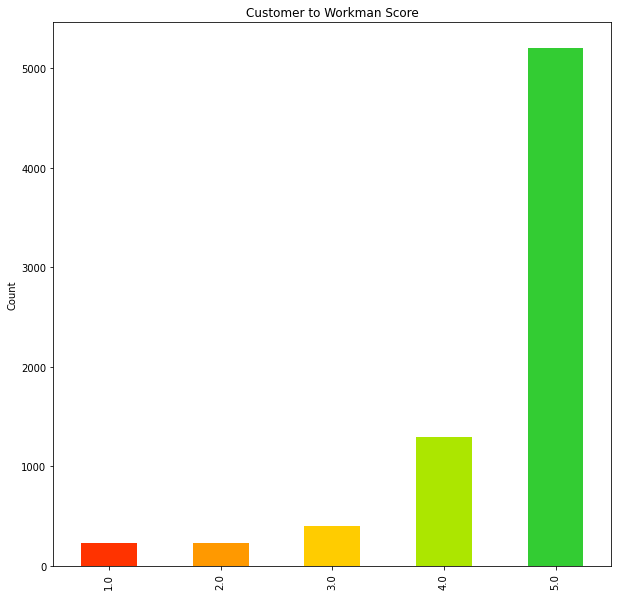

In [ ]:
data_df['Customer-to-Workman Score'].value_counts().sort_index().plot(kind = 'bar', figsize=(10,10), title = 'Customer to Workman Score',
                                    color = ['#ff3300', '#ff9900', '#ffcc00', '#ace600', '#33cc33'], ylabel = 'Count')


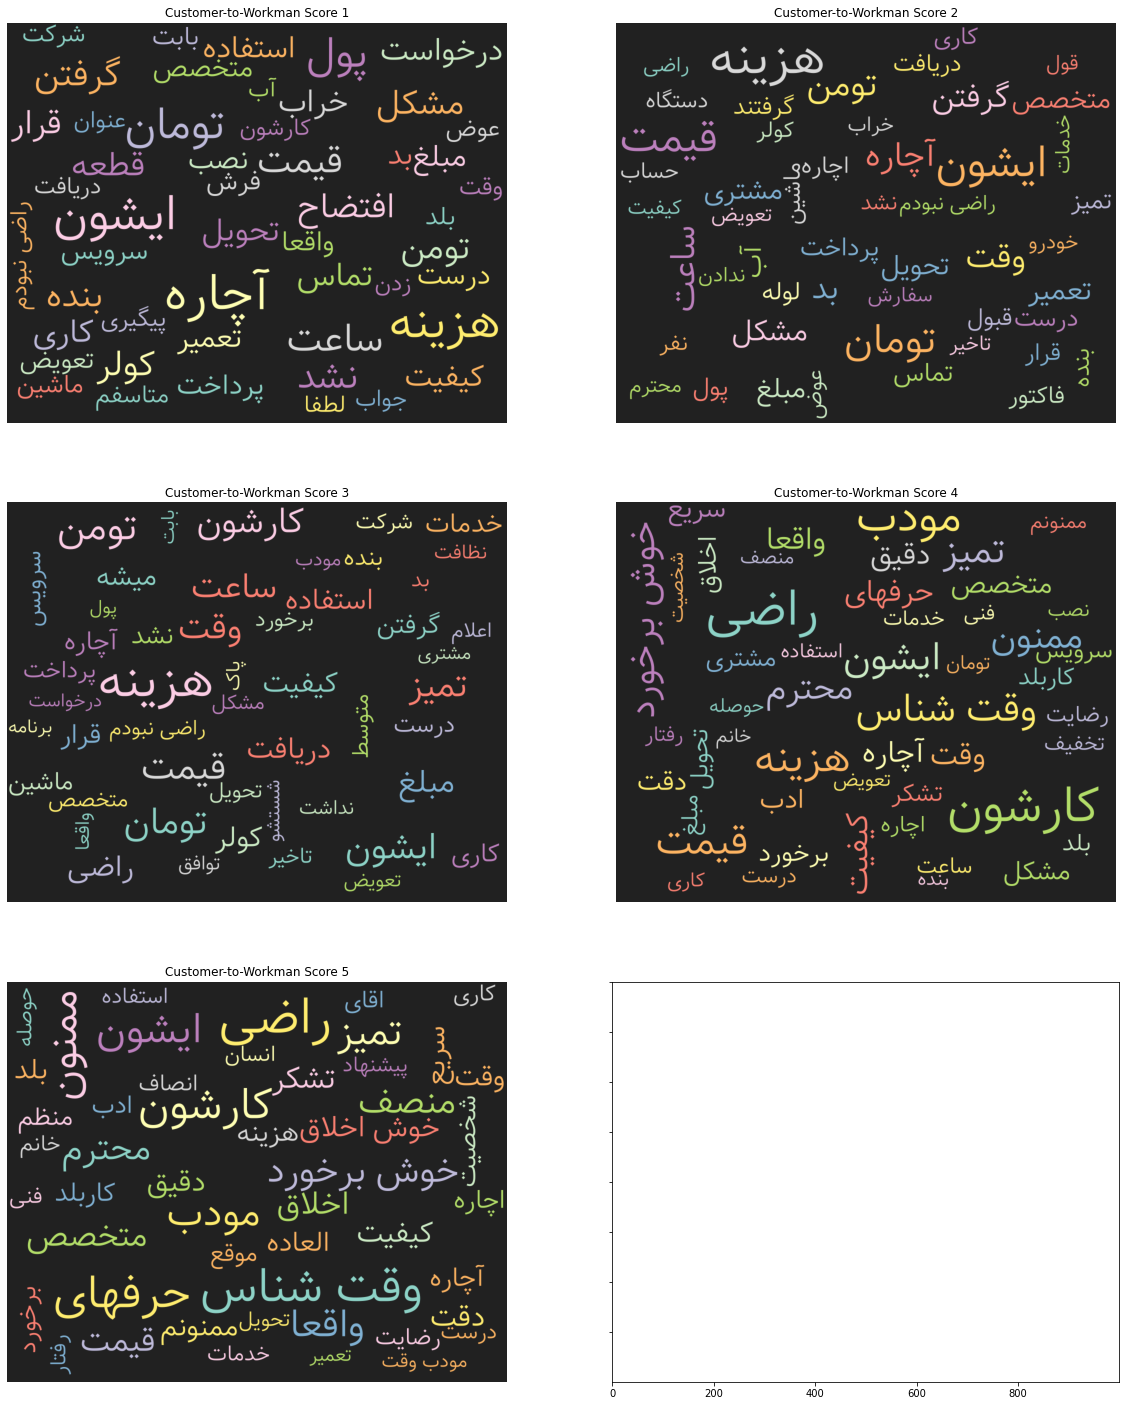

In [ ]:
score_values = list(data_df['Customer-to-Workman Score'].value_counts().index)
score_values = sorted(score_values)
row_count = len(score_values)
fig, axes = plt.subplots(nrows = int(row_count/2)+1, ncols = 2, 
                         figsize=(20,25), sharex=True, sharey=True)

comment_top_words = []

for i, ax in enumerate(axes.flatten()):
    if i >= row_count:
        break
        
    fig.add_subplot(ax)
    target_df = data_df[data_df['Customer-to-Workman Score'] == score_values[i]]
    words = target_df['Comment'].dropna().apply(word_tokenize)
   
    word=[]
    for j in words:
          word.extend(j)
    word=pd.Series(word)
 
    word=([i for i in word.str.lower() if i not in stop_words])
    word_counts = dict(Counter(word))
    word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
    comment_top_words.append(word_counts)
    
    wc = WordCloudFa(background_color="#212121",
                     max_words=50,
                     colormap='Set3', 
                     stopwords=stop_words,
                     max_font_size= 100,
                     width=1000, 
                     height=800)
   
    wc.generate(" ".join(word))
    plt.sca(ax)
    plt.gca().imshow(wc)
    plt.gca().set_title('Customer-to-Workman Score ' + str(i+1), fontdict=dict(size=12))
    plt.gca().axis('off')

<br>

##### Top words distributions

In [ ]:
commented_records = data_df[data_df['Comment'] != '']
commented_size = len(commented_records)

distributions = []

for i, top_words in tqdm(enumerate(comment_top_words)):
    top_items = list(top_words.items())[:30]
    distributions.append({})
    for item in top_items:
        item_count = item[1] / len(commented_records[commented_records['Customer-to-Workman Score'] == (i+1)]) * 100
        item_count = "{:.2f}".format(item_count)
        distributions[i][item[0]] = float(item_count)
    distributions[i] = dict(sorted(distributions[i].items(), key=lambda item: item[1], reverse=True))

0it [00:00, ?it/s]

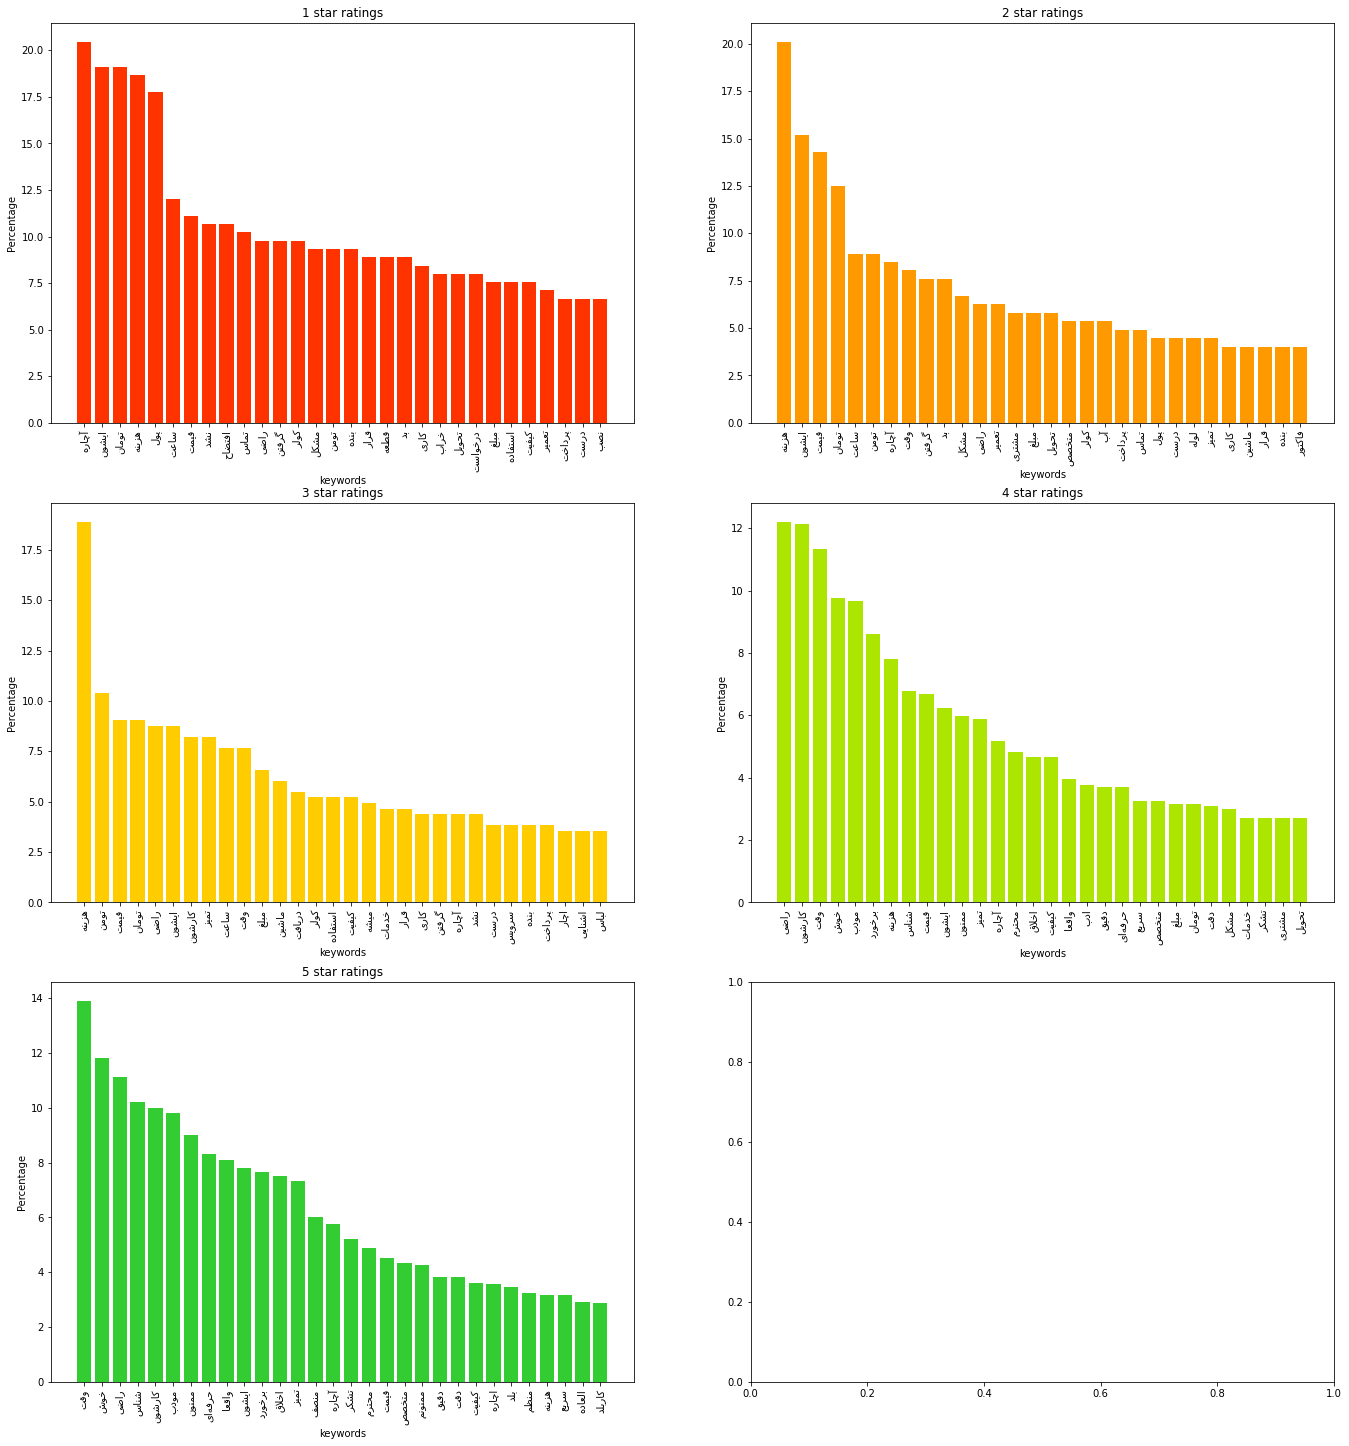

In [ ]:
colors = ['#ff3300', '#ff9900', '#ffcc00', '#ace600', '#33cc33']
fig, axes = plt.subplots(3, 2, figsize=(23,25))
for i, d in enumerate(distributions):
    (x, y) = (int(i/2), i%2)
    keywords = [make_farsi_text(k) for k in d.keys()]
    axes[x][y].bar(range(len(d)), list(d.values()), color=colors[i])
    
    plt.sca(axes[x, y])
    plt.xticks(range(len(d)), list(keywords), rotation=90)
    
    axes[x][y].set_title(str(i+1) + ' star ratings')
    axes[x][y].set_xlabel('keywords')
    axes[x][y].set_ylabel('Percentage')

<br>

##### Deciding on top keywords

In [ ]:
threshold = 5 #percent compared to comment present!

super_dict = collections.defaultdict(set)
for d in distributions:
    for k, v in d.items():
        super_dict[k].add(v)

keyword_list = list()        
        
for k, v in super_dict.items():
    if (list(v)[0] >= threshold):
        keyword_list.append(k)
        
print(len(keyword_list))
print(keyword_list)

35
['ایشون', 'پول', 'ساعت', 'نشد', 'افتضاح', 'تماس', 'راضی', 'گرفتن', 'کولر', 'مشکل', 'تومن', 'بنده', 'قرار', 'قطعه', 'بد', 'کاری', 'خراب', 'تحویل', 'درخواست', 'استفاده', 'تعمیر', 'نصب', 'وقت', 'آب', 'تمیز', 'کارشون', 'دریافت', 'خوش', 'مودب', 'برخورد', 'شناس', 'ممنون', 'واقعا', 'حرفه\u200cای', 'منصف']


<br>

##### Appending new features

In [ ]:
for col in keyword_list:
    data_df[col] = 0

for index, row in tqdm(data_df.iterrows()):
    for keyword in keyword_list:
        if (keyword in row['Comment']):
            data_df.at[index, 'Comment_' + keyword] = 1

0it [00:00, ?it/s]

<br>

#### Order Details

0it [00:00, ?it/s]

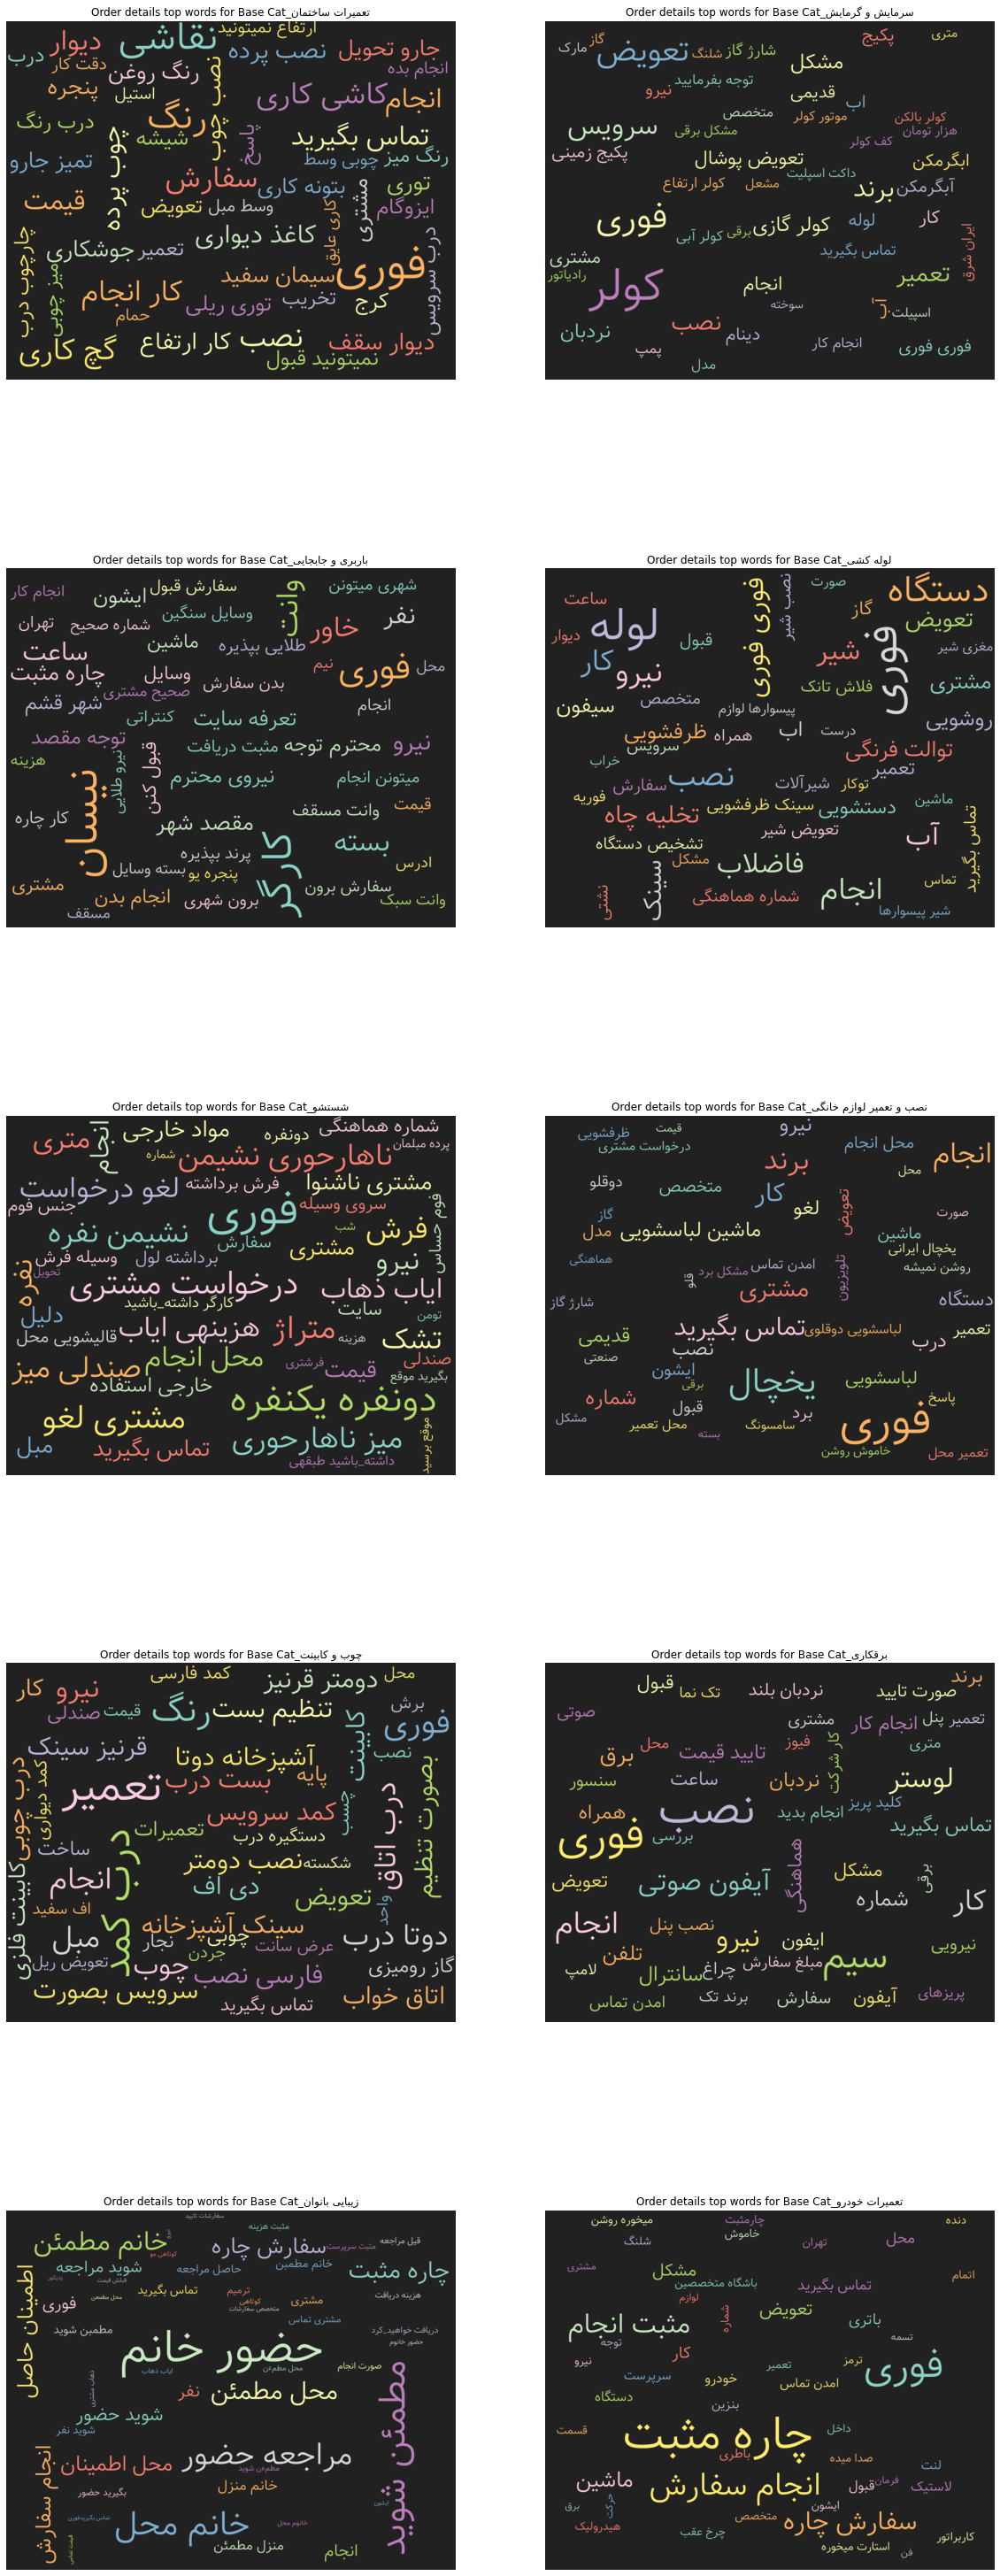

In [ ]:
base_categories = normal_base_categories[normal_base_categories > 2]
cat_values = ['Base Cat_' + cat for cat in base_categories.index.tolist()]
cat_count = len(cat_values)

fig, axes = plt.subplots(nrows = int(cat_count/2), ncols = 2, 
                         figsize=(20,55), sharex=True, sharey=True)

detail_top_words = []

for i, ax in tqdm(enumerate(axes.flatten())):
    if i >= cat_count:
        break
        
    fig.add_subplot(ax)
    target_df = data_df[data_df[cat_values[i]] != 0]
    words = target_df['Order Details'].dropna().apply(word_tokenize)
    word=[]
    for j in words:
          word.extend(j)
    word=pd.Series(word)
    word=([i for i in word.str.lower() if i not in stop_words])
    order_details_top_words = dict(Counter(word))
    order_details_top_words = dict(sorted(order_details_top_words.items(), key=lambda item: item[1], reverse=True))
    detail_top_words.append(order_details_top_words)
    
    wc = WordCloudFa(background_color="#212121",
                  #   no_reshape = True,
                     max_words=50,
                     colormap='Set3', 
                     stopwords=stop_words,
                     max_font_size= 100,
                     width=1000, 
                     height=800)
    wc.generate(" ".join(word))
    plt.sca(ax)
    plt.gca().imshow(wc)
    plt.gca().set_title('Order details top words for ' + make_farsi_text(cat_values[i]) , fontdict=dict(size=12))
    plt.gca().axis('off')

##### Word distribution

In [ ]:
detail_records = data_df[data_df['Order Details'] != '']
detail_size = len(detail_records)
distributions = []

for i, top_words in tqdm(enumerate(detail_top_words)):
    top_items = list(top_words.items())[:20]
    distributions.append({})
    for item in top_items:
        item_count = item[1] / len(detail_records[detail_records[cat_values[i]] != 0]) * 100
        item_count = "{:.2f}".format(item_count)
        distributions[i][item[0]] = float(item_count)
    distributions[i] = dict(sorted(distributions[i].items(), key=lambda item: item[1], reverse=True))

0it [00:00, ?it/s]

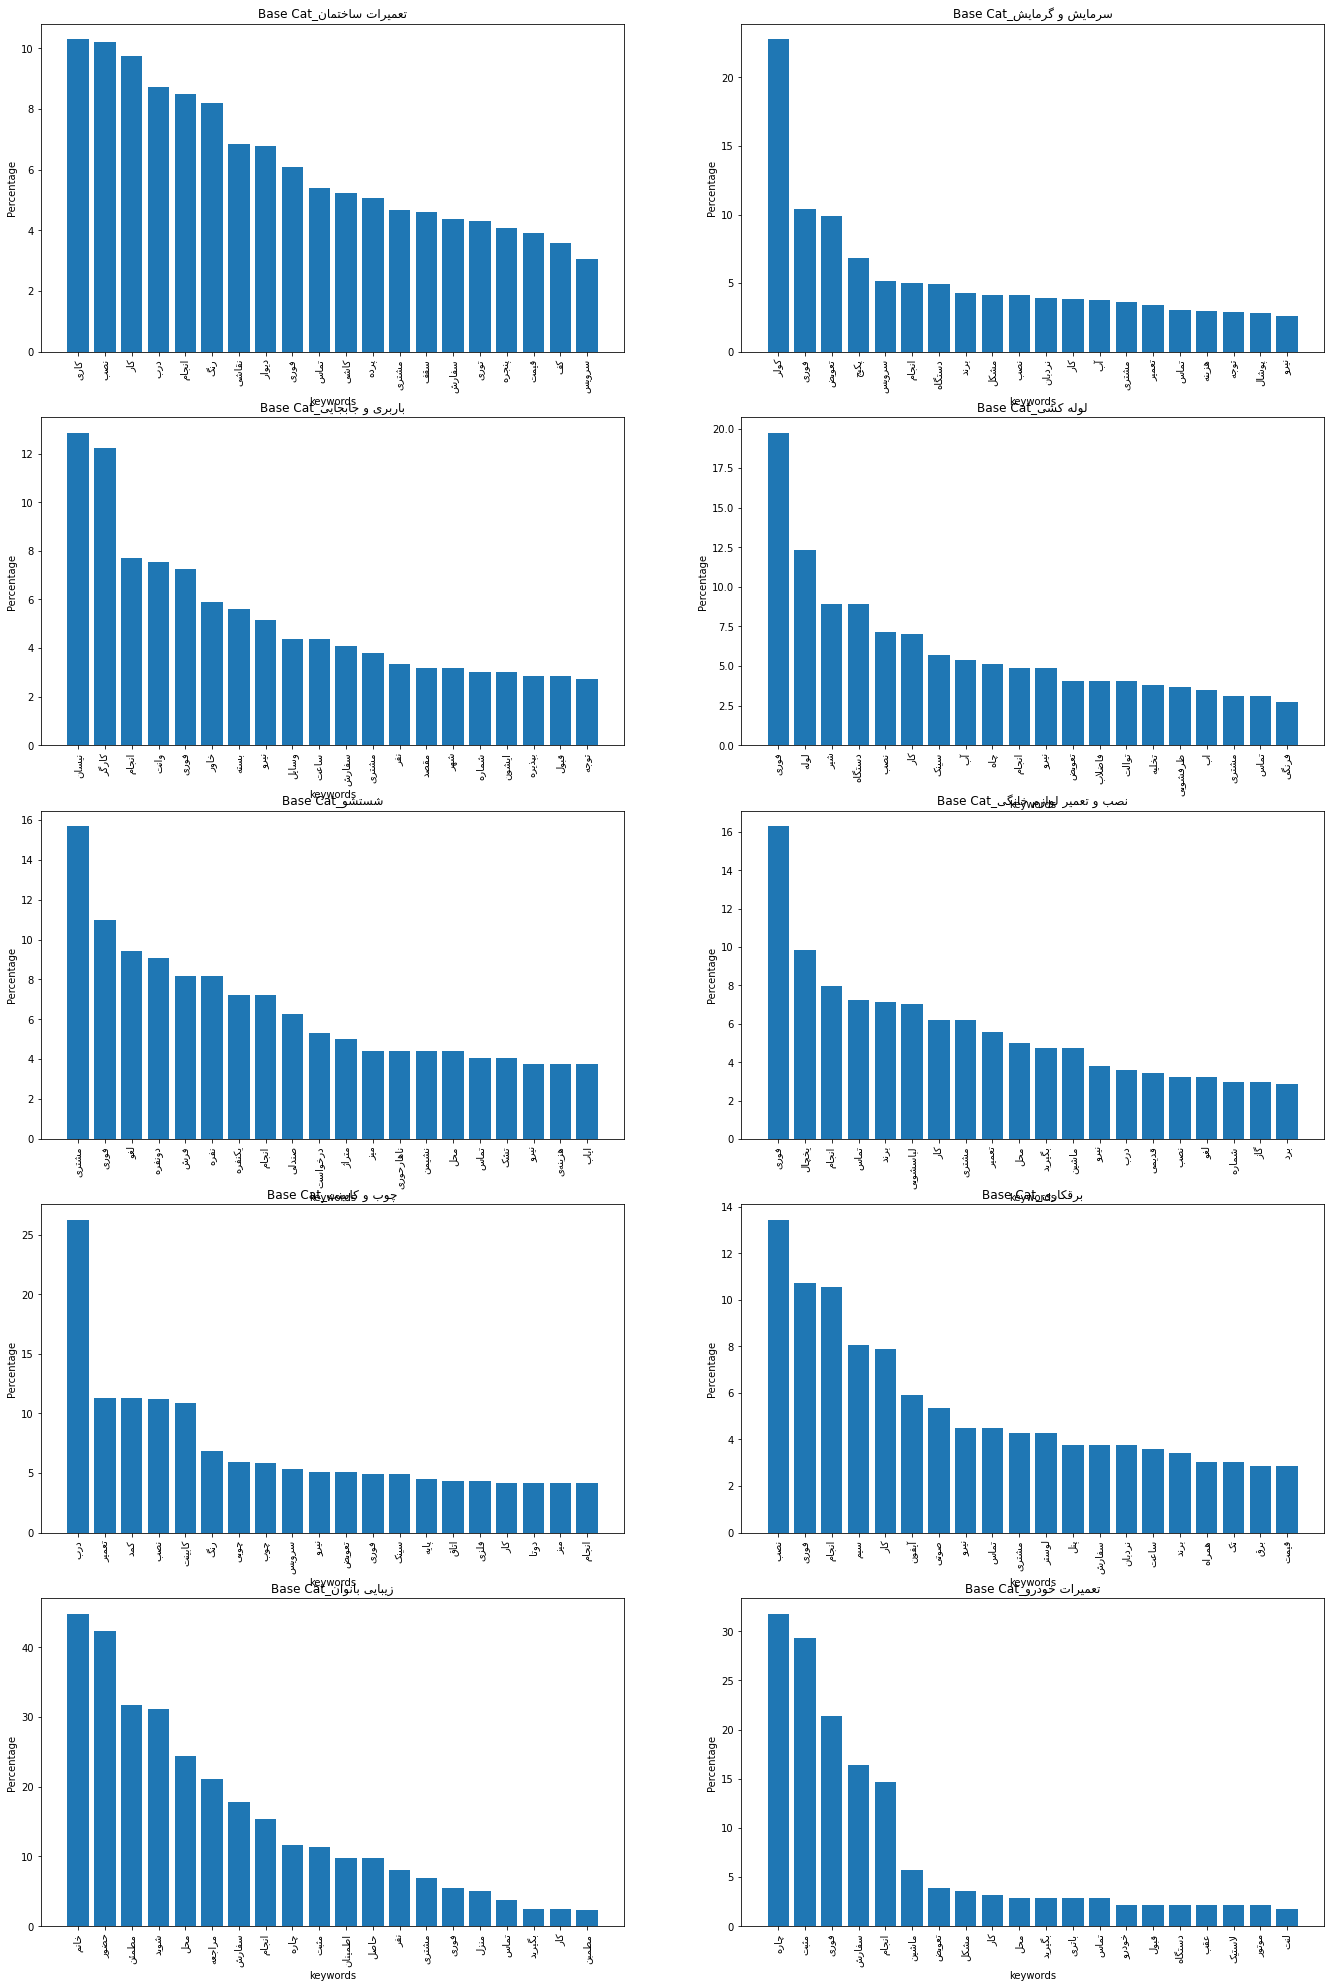

In [ ]:
fig, axes = plt.subplots(int(cat_count/2), 2, figsize=(23,35))
for i, d in enumerate(distributions):
    (x, y) = (int(i/2), i%2)
    keywords = [make_farsi_text(k) for k in d.keys()]
    axes[x][y].bar(range(len(d)), list(d.values()))
    
    plt.sca(axes[x, y])
    plt.xticks(range(len(d)), list(keywords), rotation=90)
    
    axes[x][y].set_title(make_farsi_text(cat_values[i]))
    axes[x][y].set_xlabel('keywords')
    axes[x][y].set_ylabel('Percentage')

In [ ]:
threshold = 11 #percent compared to order details present!

super_dict = collections.defaultdict(set)
for d in distributions:
    for k, v in d.items():
        super_dict[k].add(v)

keyword_list = list()        
        
for k, v in super_dict.items():
    if (list(v)[0] >= threshold):
        keyword_list.append(k)
        
print(len(keyword_list))
print(keyword_list)

14
['کولر', 'تعمیر', 'نیسان', 'کارگر', 'لوله', 'محل', 'کمد', 'خانم', 'حضور', 'مطمئن', 'شوید', 'مراجعه', 'چاره', 'مثبت']


In [ ]:
for col in keyword_list:
    data_df[col] = 0

for index, row in tqdm(data_df.iterrows()):
    for keyword in keyword_list:
        if (keyword in row['Order Details']):
            data_df.at[index, 'Order Details_' + keyword] = 1

0it [00:00, ?it/s]

<br>

#### Frauds Description

0it [00:00, ?it/s]

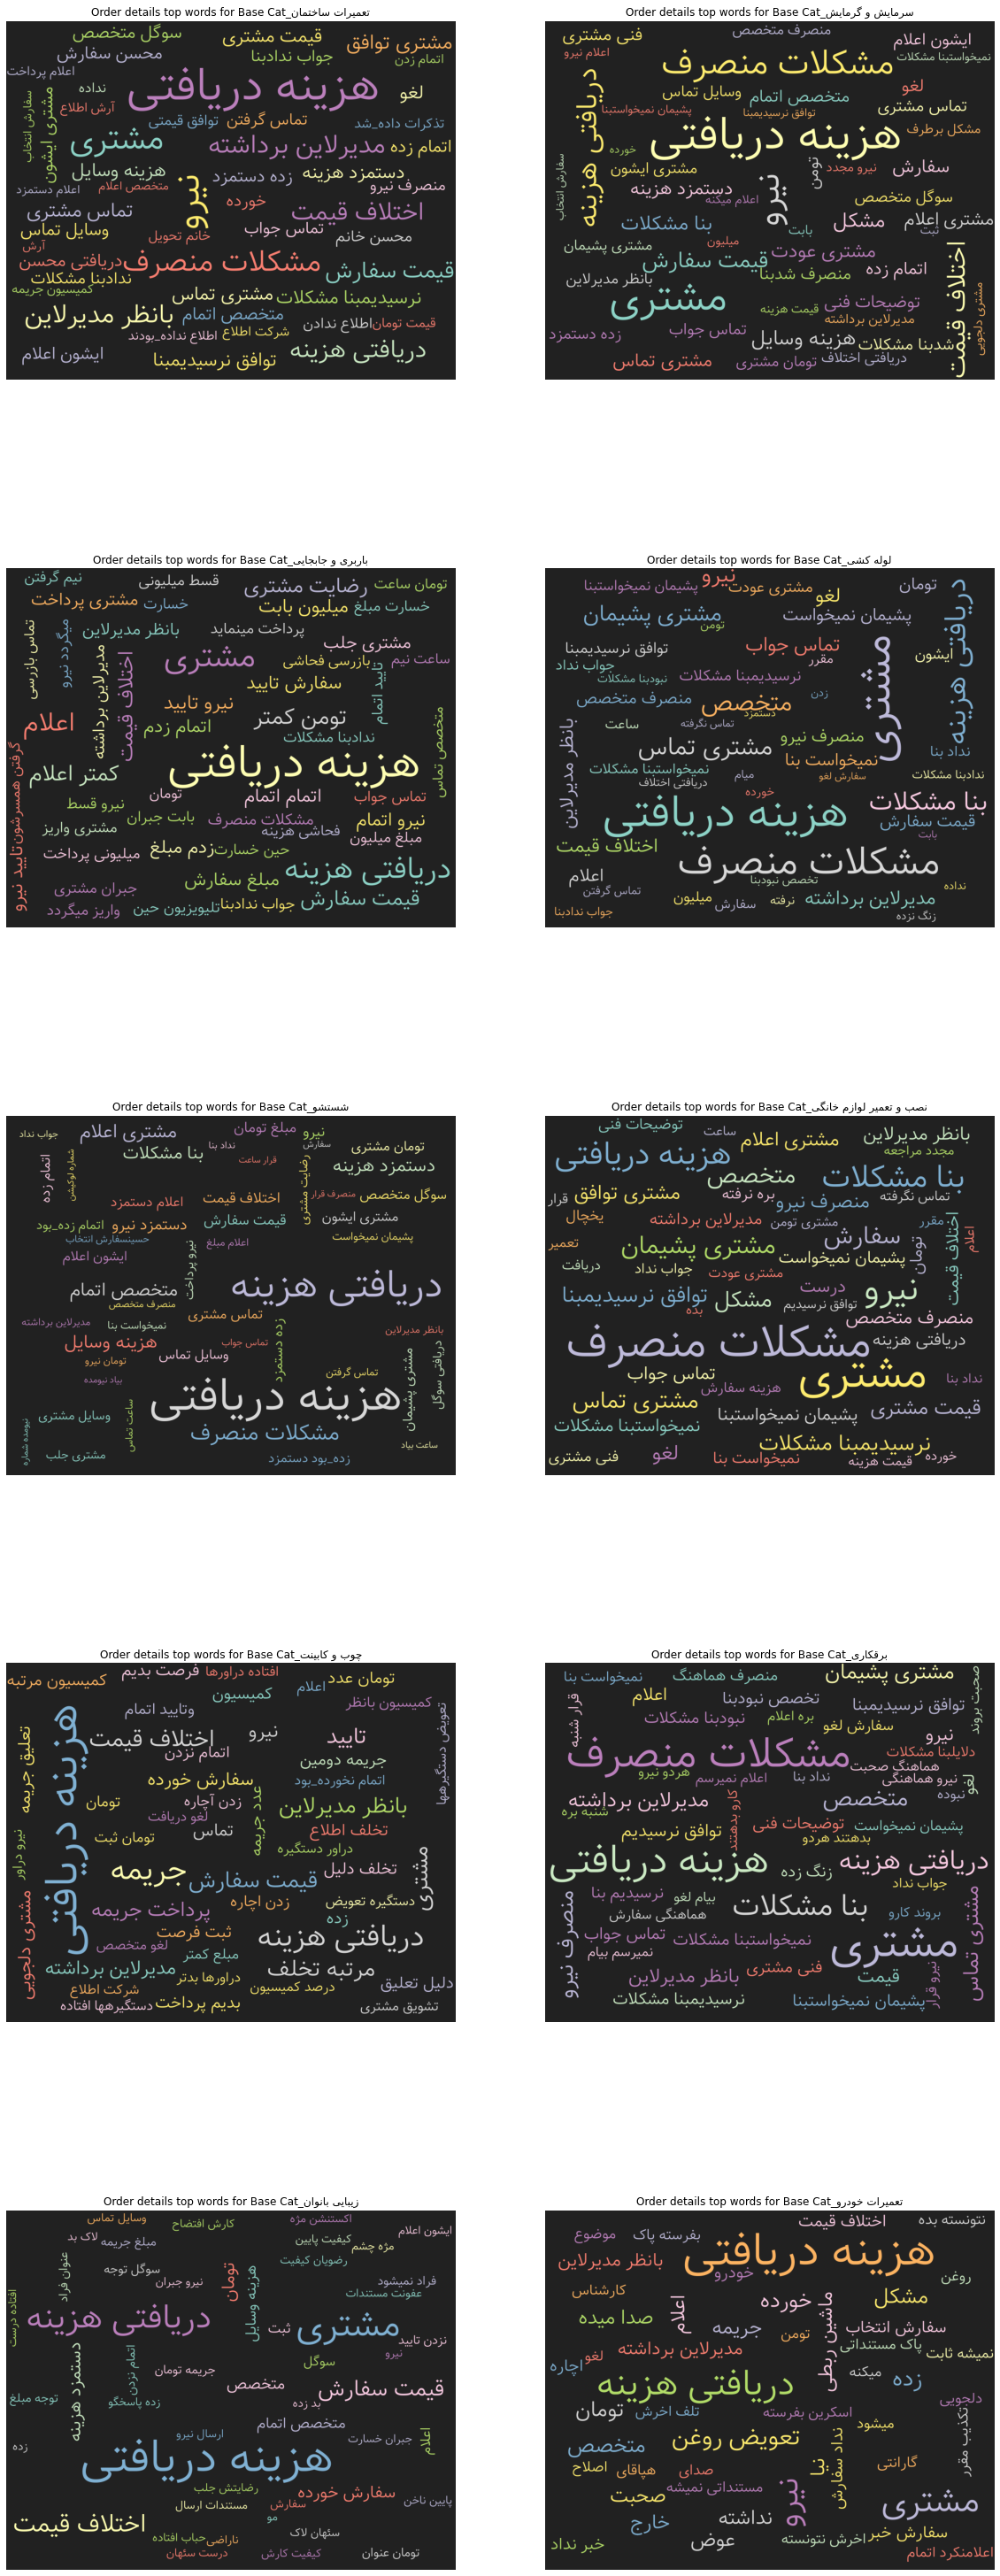

In [ ]:
base_categories = normal_base_categories[normal_base_categories > 2]
cat_values = ['Base Cat_' + cat for cat in base_categories.index.tolist()]
cat_count = len(cat_values)

fig, axes = plt.subplots(nrows = int(cat_count/2), ncols = 2, 
                         figsize=(20,55), sharex=True, sharey=True)

detail_top_words = []

for i, ax in tqdm(enumerate(axes.flatten())):
    if i >= cat_count:
        break
        
    fig.add_subplot(ax)
    target_df = data_df[data_df[cat_values[i]] != 0]
    words = target_df['Frauds Description'].dropna().apply(word_tokenize)
    word=[]
    for j in words:
          word.extend(j)
    word=pd.Series(word)
    word=([i for i in word.str.lower() if i not in stop_words])
    order_details_top_words = dict(Counter(word))
    order_details_top_words = dict(sorted(order_details_top_words.items(), key=lambda item: item[1], reverse=True))
    detail_top_words.append(order_details_top_words)
    
    wc = WordCloudFa(background_color="#212121",
                  #   no_reshape = True,
                     max_words=50,
                     colormap='Set3', 
                     stopwords=stop_words,
                     max_font_size= 100,
                     width=1000, 
                     height=800)
    wc.generate(" ".join(word))
    plt.sca(ax)
    plt.gca().imshow(wc)
    plt.gca().set_title('Order details top words for ' + make_farsi_text(cat_values[i]) , fontdict=dict(size=12))
    plt.gca().axis('off')

In [ ]:
data_df

### Topic modeling of comments

In [ ]:
data_df['tokens'] = data_df['Comment'].progress_apply(lambda c: word_tokenize(c))
commented_data = data_df[data_df['Comment'] != '']

  0%|          | 0/2989150 [00:00<?, ?it/s]

In [ ]:
token_list = data_df['tokens'].to_list()

In [ ]:
def get_dictionary(tokens):
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)    
    return dictionary

In [ ]:
def get_bow_corpus(dictionary, tokens):
    return [dictionary.doc2bow(doc) for doc in tokens]

In [ ]:
dictionary = get_dictionary(token_list)
corpus = get_bow_corpus(dictionary, token_list)

#### Best params for LDA

In [ ]:
lda_topic_model = gensim.models.LdaMulticore(corpus, num_topics= 8, id2word=dictionary, passes= 20)
coherence_model_lda = CoherenceModel(model=lda_topic_model, texts=token_list, dictionary=dictionary, coherence='c_v')
coherence_value = coherence_model_lda.get_coherence()
coherence_value

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


0.38694374556393213

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_topic_model, corpus, dictionary=lda_topic_model.id2word, n_jobs=1)
pyLDAvis.save_html(vis, 'comment_lda_result.html')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.244728 -0.345983       1        1  15.548648
2      0.203513  0.001507       2        1  14.468579
0     -0.184943  0.132263       3        1  13.229211
7      0.146345 -0.034760       4        1  12.398303
3      0.047663  0.011819       5        1  11.551703
4     -0.129436  0.292139       6        1  11.543012
1      0.225074 -0.075540       7        1  10.780581
6     -0.063488  0.018555       8        1  10.479962, topic_info=         Term        Freq       Total Category  logprob  loglift
65        خوش  737.000000  737.000000  Default  30.0000  30.0000
2        مودب  710.000000  710.000000  Default  29.0000  29.0000
7         وقت  649.000000  649.000000  Default  28.0000  28.0000
46       راضی  647.000000  647.000000  Default  27.0000  27.0000
36     کارشون  689.000000  689.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
80     دستمزد   33.156655   33.877096   Topic8  -4.3736   2.2342
207  اپلیکیشن   29.475908   30.194063   Topic8  -4.4913   2.2316
334      صبور   29.003961   29.722403   Topic8  -4.5074   2.2312
319    موفقیت   41.084511   42.945902   Topic8  -4.1592   2.2114
84      شریفی   34.287738   36.689760   Topic8  -4.3401   2.1880

[280 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
384       2  0.981542     آب
384       4  0.011154     آب
235       6  0.975731    آدم
184       5  0.995566  آمدند
217       2  0.992763   آچار
...     ...       ...    ...
285       3  0.985230    گرم
312       3  0.900052  یخچال
312       5  0.078265  یخچال
348       6  0.932249      👍
219       1  0.990823      🙏

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 8, 4, 5, 2, 7])

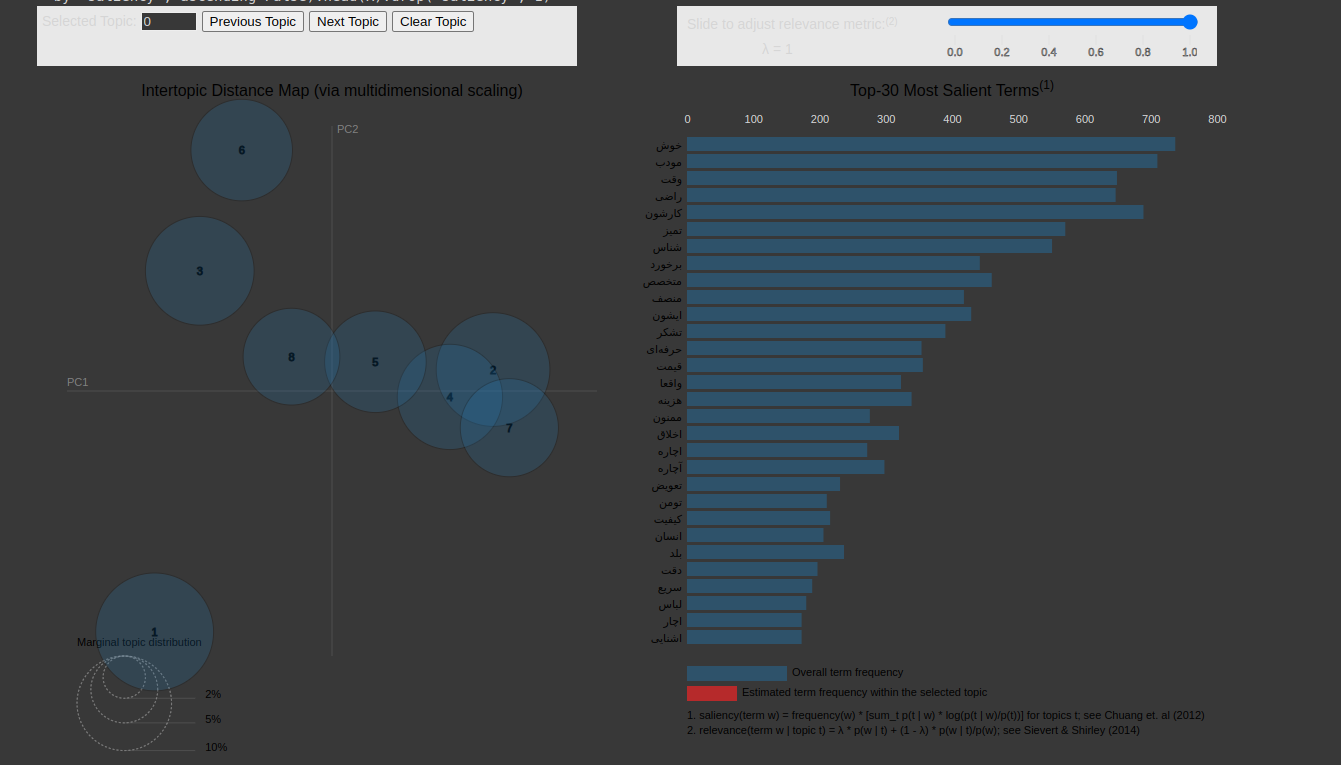

#### Merging topic indexes with original df

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=token_list):
    sent_topics = {'lda_topic': [], 'lda_topic_perc': []}

    for i, row_list in enumerate(tqdm(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)        
        topic_num = row[0][0]
        prop_topic = row[0][1]
        sent_topics['lda_topic'].append(topic_num)
        sent_topics['lda_topic_perc'].append(prop_topic)
         
    sent_topics_df = pd.DataFrame.from_dict(sent_topics)

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_topic_model, corpus=corpus, texts=token_list)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'text']

data_df['topic_model'] = df_dominant_topic['Dominant_Topic']

  0%|          | 0/2989150 [00:00<?, ?it/s]